In [1]:
%%capture
!pip install razdel
!pip install pyLDAvis
!pip install pymorphy2
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model
!pip install clean-text
!pip install numpy --upgrade
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from collections import Counter
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
import networkx as nx
from razdel import sentenize
from razdel import tokenize
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import json
import requests
from urllib.request import urlopen
import string
from tqdm.notebook import tqdm
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
import matplotlib.pyplot as plt
import matplotlib
from pymorphy2 import MorphAnalyzer
import time
from cleantext import clean
import warnings
import re
import sys
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import community
import networkx as nx
import pickle
import random
warnings.filterwarnings("ignore")

In [2]:
# Create app at dev.vk.com/api
vk_config = {"token": "7cfd33327cfd33327cfd3332517fe9377977cfd7cfd333218a3a1b68df24f9c48afe7a3",  # Токен приложения
             "client_id": "51643467", #ID приложения
             "version": "5.131",  # Версия
             "domain": "https://api.vk.com/method/"}  # Домен для запросов

# ***Сбор пользователей***

In [3]:
def get_offset(group_id):                                                            # Параметры для запуска функции: ID группы
    """Получение параметра offset для группы (1 offset ~ 1000 id)."""
    params = {'access_token': vk_config["token"], 'group_id': group_id, 'v': vk_config["version"]}  # Параметры
    r = requests.get('https://api.vk.com/method/groups.getMembers', params=params)   # Запрос для получения подписчиков сообщества
    count = r.json()['response']['count']                                            # Получение количества подписчиков в сообществе
    print(f'Количество подписчиков: {count}')                                        # Вывод количества подписчиков в сообществе
    if count > 1000:                                                                 # Условие №1: если количество подписчиков в сообществе больше тысячи, 
        return count // 1000                                                         # то функция возвращает результат целочисленного деления количества подписчиков на тысячу
    else:                                                                            # Условие №1: если же количество подписчиков в сообществе меньше или равно тысячи,
        count = 1                                                                    # то функция возвращает единицу
        return count

In [4]:
def get_users(group_id):                                                                                         # Параметры для запуска функции: ID группы
    """Получение всех участников группы"""
    user_list = []                                                                                               # Создаём пустой список, в который будем добавлять ID подписчиков
    for offset in range(0, get_offset(group_id) + 1):                                                            # Создаём цикл for для получения всех подписчиков сообщества с помощью функции из ячейки выше
        params = {'access_token':  vk_config["token"], 'v': 5.131, 'group_id': group_id, 'offset': offset*1000}  # Параметры
        users = requests.get('https://api.vk.com/method/groups.getMembers', params=params).json()['response']    # Запрос для получения подписчиков сообщества
        for user in users["items"]:                                                                              # Обращаемся к полю "items", в котором хранятся ID подписчиков
          user_list.append(user)                                                                                 # Добавляем ID подписчиков в созданный на 3 строке список
    return user_list                                                                                             # Функция возвращает список

id_1 = 38829395
id_2 = 97561908
clubname_1 = "bfsistema"
clubname_2 = "fbl.russia"
rosmol = get_users(id_1)                                                                                    
tvoyhod = get_users(id_2)                                                                                   

Количество подписчиков: 6200
Количество подписчиков: 11234


# ***Поиск пересечений***

In [5]:
common = set(tvoyhod).intersection(rosmol)  # Ищем пересечения среди подписчиков обоих сообществ
common = list(common)                   # Переделываем получившийся результат в список
len(common)                             # Выводим длину списка, которая и будет равна количеству человеке, относящихся к обоим сообществам  

130

# ***Сбор текстов постов***

In [6]:
def get_offset_wall(group_id, domain, amount):                                                            # Параметры для запуска функции: ID группы, домен группы, нужное количество постов
    """Выявляем параметр offset для групп, 1 offset ~ 20 id"""
    params = {'access_token': vk_config["token"], 'owner_id': -1*group_id, 'domain': domain, 'v': 5.131}  # Параметры
    r = requests.get('https://api.vk.com/method/wall.get', params=params)                                 # Запрос для получения постов сообщества 
    count = r.json()['response']['count']                                                                 # Получение количества постов сообщества
    print(f'Количество постов: {count}')                                                                  # Вывод количества постов сообщества
    return (amount // 20)                                                                                 # Функция возвращает результат целочисленного деления количества постов сообщества на двадцать

In [7]:
def get_posts(group_id, domain, amount):                                                                                       # Параметры для запуска функции: ID группы, домен группы, нужное количество постов
  """Получаем нужное количество постов из группы и сохраняем текст записей"""
  text_list = []                                                                                                               # Создаём пустой список, в который будем добавлять тексты постов сообщества
  for offset in range(0, get_offset_wall(group_id, domain, amount)):                                                           # Создаём цикл для получения постов сообщества с помощью функции из ячейки выше
    params = {'access_token': vk_config["token"], 'owner_id': -1*group_id, 'domain': domain, 'offset': offset*20, 'v': 5.131}  # Параметры 
    r = requests.get('https://api.vk.com/method/wall.get', params=params)                                                      # Запрос для получения постов сообщества
    data = r.json()                                                                                                            # Переводим полученные результаты в формат json
    data = data['response']['items']                                                                                           # Обращаемся к полю "items", в котором хранится информация о постах
    for i in range(len(data)):                                                                                                 # Создаём цикл для работы с каждым отдельным постом
      if len(text_list) < amount:                                                                                              # Условие №1: если размер списка, созданного в строке 3, меньше двух тысяч,
        text_list.append(data[i]['text'])                                                                                      # то обращаемся к полю "text" и сохраняем текст рассматриваемого поста
      else:                                                                                                                    # Условие №1: если же размер списка больше или равен 2000, 
        break                                                                                                                  # то прерываем выполнение программы и переходим к следующей строке
  return text_list                                                                                                             # Функция возвращает список текстов последних двух тысяч записей из сообщества

rosmol_posts = get_posts(id_1, clubname_1, 2000)                                                                           # Используем функцию сбора текстов постов для сообщества "Нейронауки"
tvoyhod_posts = get_posts(id_2, clubname_2, 2000)                                                                         # Используем функцию сбора текстов постов для сообщества "Data Science"

Количество постов: 2416
Количество постов: 2254


In [8]:
print(len(rosmol_posts))  # Проверка количества текстов записей для сообщества "Росмолодежь"
print(len(tvoyhod_posts))   # Проверка количества текстов записей для сообщества "Твой Ход"

2000
2000


# ***Подсчёт количества хэштегов***

In [9]:
def remove_emoji(string):                                                       # Параметры для запуска функции: строка (в нашем случае это текст записи)                                                
  """Функция для очистки строки от эмодзи"""
  emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"                     # Сбор всех возможных смайликов и эмодзи  
                              u"\U0001F300-\U0001F5FF"  
                              u"\U0001F680-\U0001F6FF"  
                              u"\U0001F1E0-\U0001F1FF"  
                              u"\U00002500-\U00002BEF"  
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f" 
                              u"\u3030"
                              u"\u23F0" "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string)                                       # Функция возвращает строку, в которой смайлики и эмодзи заменены на пустой символ ''

def emojies(list_name):                                                         # Параметры для запуска функции: список с текстами записей сообщества
  """Функция для очистки всех текстов постов в списке от эмодзи и смайликов"""  
  for i in range(len(list_name)):                                               # Создаём цикл, который проходит по каждой строке списка
    list_name[i] = remove_emoji(list_name[i])                                   # Обновляем каждую строку списка, прогоняя её через функцию remove_emojies
  return list_name                                                              # Возвращаем изменённый список

rosmol_posts_no_emojies = emojies(rosmol_posts)                                   # Используем функцию очистки текстов постов сообщества "Росмолодежь" от эмодзи
tvoyhod_posts_no_emojies = emojies(tvoyhod_posts)                                   # Используем функцию очистки текстов постов сообщества "Твой Ход" от эмодзи

In [10]:
def clear(list_name):                                                  # Параметры для запуска функции: список с текстами записей сообщества
  """Функция для очистки всех текстов постов от ненужных символов"""
  marks = "\n"                                                         # Первый символ для удаления: \n
  marks2 = "»" 
  marks22 = "«"                                                        # Второй символ для удаления: »
  for i in range(len(list_name)):                                      # Создаём цикл, который проходит по каждой строке списка 
    list_name[i] = list_name[i].replace(marks, " ")                    # Обновляем каждую строку списка, заменяя символ \n на символ пробела
    list_name[i] = list_name[i].replace(marks2, " ")                   # Обновляем каждую строку списка, заменяя символ » на символ пробела
    list_name[i] = list_name[i].replace(marks22, " ")                  # Обновляем каждую строку списка, заменяя символ « на символ пробела
  return list_name                                                     # Возвращаем изменённый список

rosmol_posts_cleared = clear(rosmol_posts_no_emojies)                    # Используем функцию очистки текстов постов сообщества "Росмолодежь" от ненужных символов
tvoyhod_posts_cleared = clear(tvoyhod_posts_no_emojies)                      # Используем функцию очистки текстов постов сообщества "Твой Ход" от ненужных символов

In [11]:
def hashes(list_name):                                      # Параметры для запуска функции: список с текстами записей сообщества 
  """Функция для добавления хэштегов в отдельный список"""
  hashtag_list = []                                         # Создаём пустой список, в который будем добавлять хэштеги
  for i in range(len(list_name)):                           # Создаём цикл, который проходит по каждой строке списка
    for word in list_name[i].split():                       # Создаём цикл, который проходит по каждому слову в строке
      if '#' in word and '@' in word:                       # Условие №1: если в слове есть символы "#" и "@",
        index = word.find("#")                              # то находим индекс символа "#" и 
        dog = word.find("@")                                # находим индекс символа "@"
        hashtag_list.append(word[index:dog])                # Добавляем в список слово, ограничивая его найденными ранее индексами (чтобы @ не попала в хештэг)
      elif '#' in word:                                     # Условие №1: если же в слове есть только символ "#",
        index = word.find("#")                              # то находим индекс символа "#" и 
        hashtag_list.append(word[index:])                   # добавляем в список слово, ограничивая его найденным индексом
  return hashtag_list                                       # Возвращаем изменённый список

rosmol_hashes = hashes(rosmol_posts_cleared)                  # Используем функцию поиска хэштегов для текстов постов сообщества "Росмолодежь"
tvoyhod_hashes = hashes(tvoyhod_posts_cleared)                    # Используем функцию поиска хэштегов для текстов постов сообщества "Твой Ход"

In [12]:
def punctuation(list_name):                                                           # Параметры для запуска функции: список с хэштегами
  """Функция для удаления пунктуации из списка хэштегов"""
  for i in range(len(list_name)):                                                     # Создаём цикл, который проходит по каждому хэштегу
    list_name[i] = list_name[i].translate(str.maketrans('', '', string.punctuation))  # Удаляем пунктуацию из каждого хэштега (у нас встречались хэштеги по типу '#Голос,', поэтому мы убираем знаки препинания)
  return list_name                                                                    # Возвращаем изменённый список 

rosmol_hashes = punctuation(rosmol_hashes)                                              # Используем функцию удаления пунктуации для хэштегов сообщества "Росмолодежь"
tvoyhod_hashes = punctuation(tvoyhod_hashes)                                                # Используем функцию удаления пунктуации для хэштегов сообщества "Твой Ход"

In [13]:
def hashes_add(list_name):                                                         # Параметры для запуска функции: список с хэштегами 
  """Функция для добавления символа '#' обратно после удаления всей пунктуации"""
  hash = "#"                                                                       # Определяем символ '#' в переменную
  i = 0                                                                            # Определяем переменную i и задаём ей значение 0
  while i < len(list_name):                                                        # Создаём цикл, который работает, пока i меньше длины переданного в функцию списка
    if list_name[i].isdigit() == True:                                             # Условие №1: если хэштег состоит только из цифр,
      list_name.pop(i)                                                             # то удаляем его из списка
    elif list_name[i].isdigit() == False:                                          # Условие №1: если же хэштег не состоит только из цифр,
      list_name[i] = hash + list_name[i]                                           # то добавляем символ '#' в начало строки с хэштегом и
      i += 1                                                                       # увеличиваем значение переменной i на единицу
  return list_name                                                                 # Возвращаем изменённый список

rosmol_hashes = hashes_add(rosmol_hashes)                                            # Используем функцию добавления символа '#' для хэштегов сообщества "Росмолодежь"
tvoyhod_hashes = hashes_add(tvoyhod_hashes)                                              # Используем функцию добавления символа '#' для хэштегов сообщества "Твой Ход"

In [14]:
rosmol_hashes_df = pd.DataFrame({"hashes": rosmol_hashes})  # Переделываем список хэштегов сообщества "Росмол" в датасет и называем новый столбец 'hashes'
rosmol_hashes_values = rosmol_hashes_df.value_counts()      # Считаем количество вхождений каждого отдельного хэштега
rosmol_hashes_values = pd.DataFrame(rosmol_hashes_values)   # Переделываем полученный результат в датасет
rosmol_hashes_values = rosmol_hashes_values.reset_index()   # Сбрасываем индекс
rosmol_hashes_values.columns.values[1] = "amount"          # Переименовываем столбец с количеством хэштегов в 'amount'

In [15]:
tvoyhod_hashes_df = pd.DataFrame({"hashes": tvoyhod_hashes})  # Переделываем список хэштегов сообщества "Твой Ход" в датасет и называем новый столбец 'hashes'
tvoyhod_hashes_values = tvoyhod_hashes_df.value_counts()      # Считаем количество вхождений каждого отдельного хэштега
tvoyhod_hashes_values = pd.DataFrame(tvoyhod_hashes_values)   # Переделываем полученный результат в датасет
tvoyhod_hashes_values = tvoyhod_hashes_values.reset_index()   # Сбрасываем индекс 
tvoyhod_hashes_values.columns.values[1] = "amount"         # Переименовываем столбец с количеством хэштегов в 'amount'

[Text(0, 0, '269'),
 Text(0, 0, '232'),
 Text(0, 0, '167'),
 Text(0, 0, '102'),
 Text(0, 0, '89'),
 Text(0, 0, '87'),
 Text(0, 0, '84'),
 Text(0, 0, '82'),
 Text(0, 0, '67'),
 Text(0, 0, '58'),
 Text(0, 0, '45'),
 Text(0, 0, '44'),
 Text(0, 0, '42'),
 Text(0, 0, '42'),
 Text(0, 0, '36'),
 Text(0, 0, '34'),
 Text(0, 0, '31'),
 Text(0, 0, '31'),
 Text(0, 0, '31'),
 Text(0, 0, '30'),
 Text(0, 0, '29'),
 Text(0, 0, '27'),
 Text(0, 0, '27'),
 Text(0, 0, '25'),
 Text(0, 0, '25'),
 Text(0, 0, '24'),
 Text(0, 0, '23'),
 Text(0, 0, '23'),
 Text(0, 0, '22'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '17'),
 Text(0, 0, '17'),
 Text(0, 0, '17'),
 Text(0, 0, '16'),
 Text(0, 0, '16'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '11'),
 Text(0, 0, '11'),
 Text(0, 0, '11'),
 Text(0, 0, '11'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '9'),
 Text(0, 0

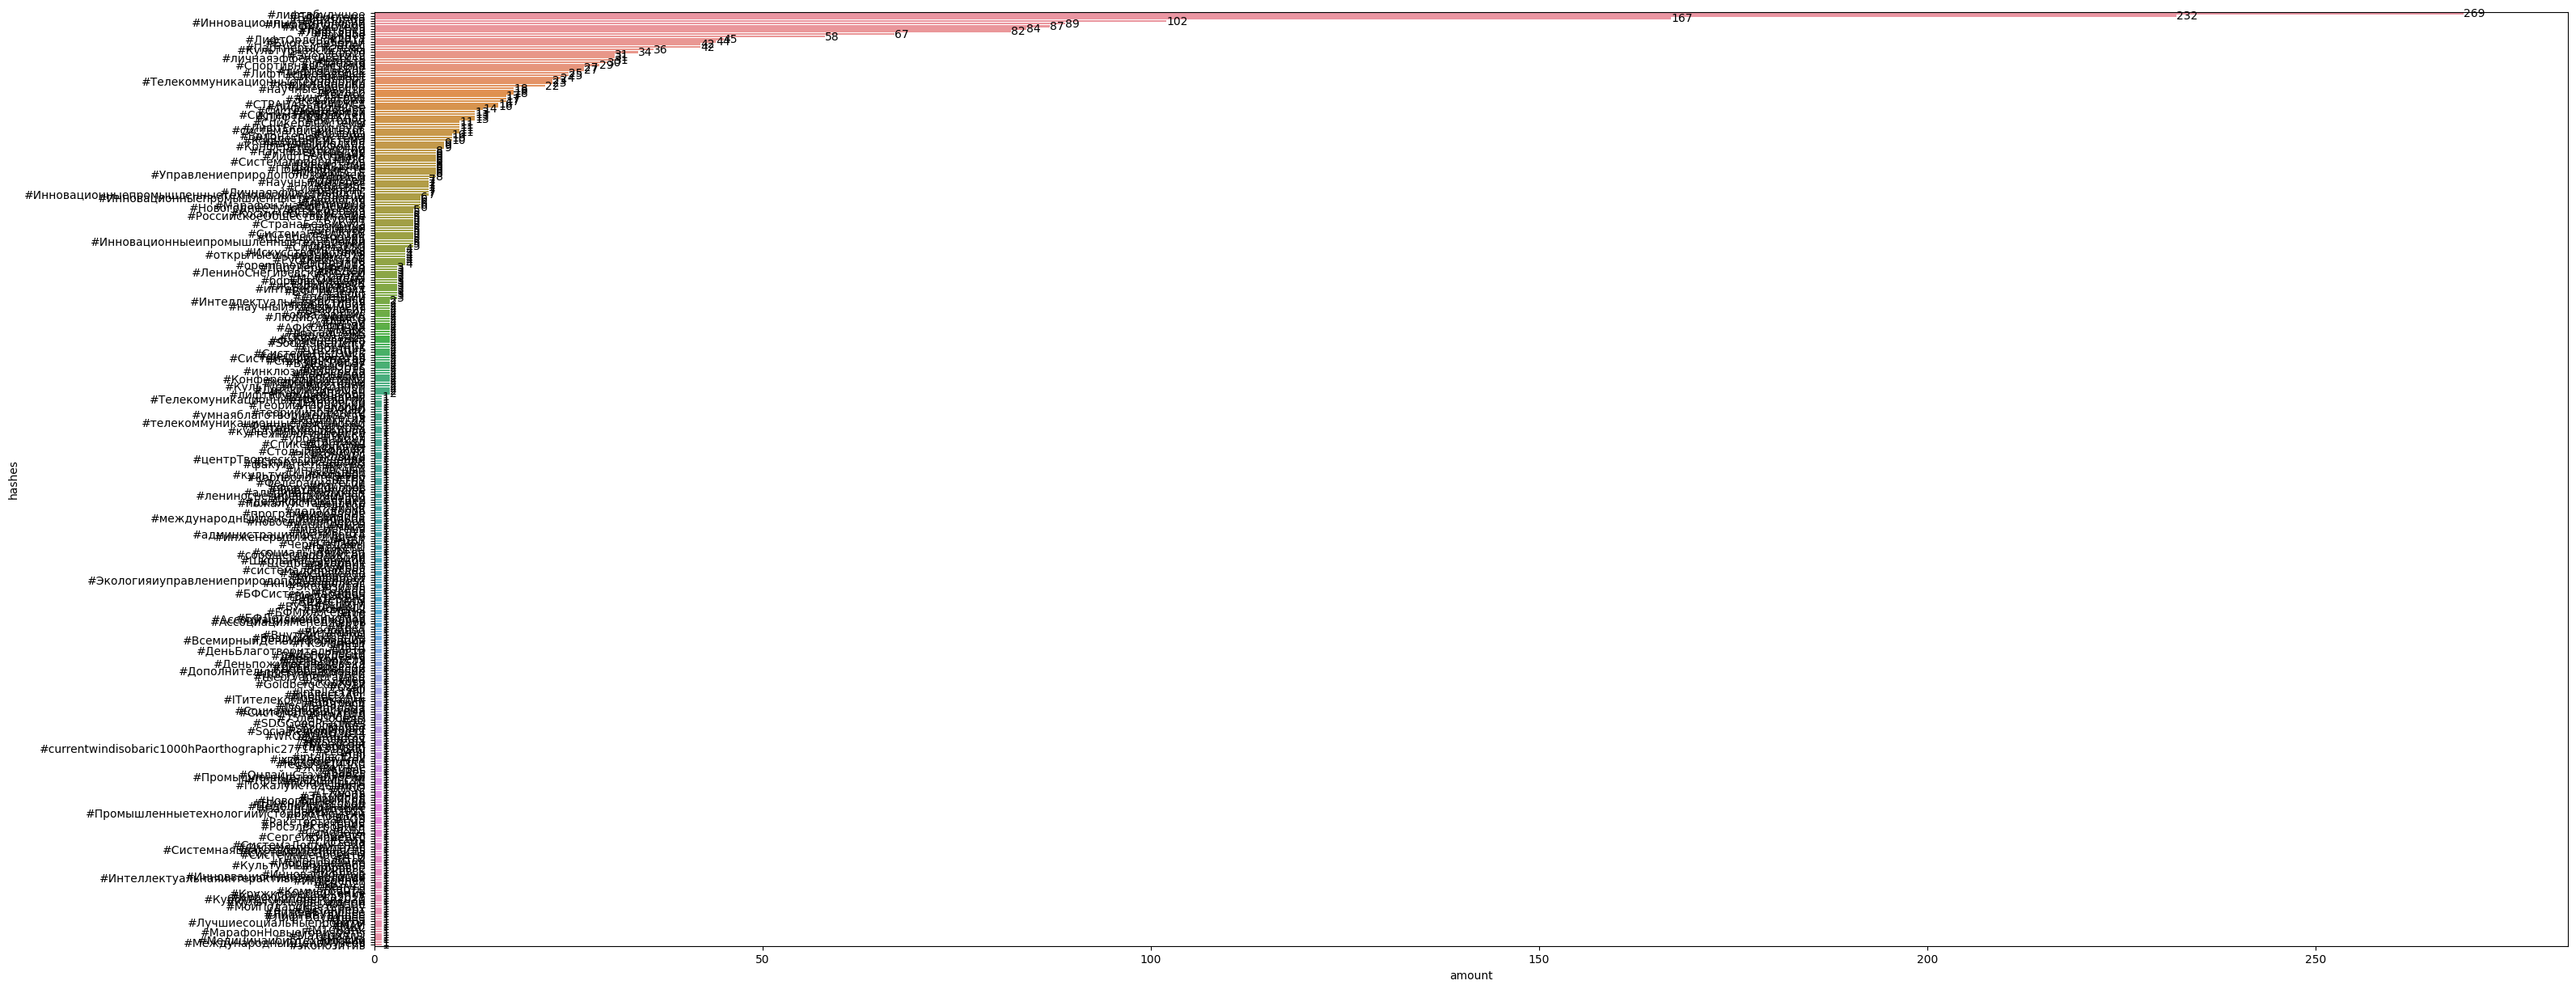

In [16]:
fig, ax = pyplot.subplots(figsize=(35, 15))                           # Задаём размер графика для хэштегов сообщества "Росмолодежь"
sns.barplot(ax=ax, data=rosmol_hashes_values, x="amount", y="hashes")  # Строим столбчатую диаграмму с заданными параметрами
ax.bar_label(ax.containers[0], label_type='edge')                     # Применяем параметр для вывода количества хэштегов на график

[Text(0, 0, '1664'),
 Text(0, 0, '568'),
 Text(0, 0, '216'),
 Text(0, 0, '197'),
 Text(0, 0, '147'),
 Text(0, 0, '117'),
 Text(0, 0, '99'),
 Text(0, 0, '87'),
 Text(0, 0, '84'),
 Text(0, 0, '68'),
 Text(0, 0, '58'),
 Text(0, 0, '34'),
 Text(0, 0, '28'),
 Text(0, 0, '26'),
 Text(0, 0, '24'),
 Text(0, 0, '24'),
 Text(0, 0, '24'),
 Text(0, 0, '24'),
 Text(0, 0, '21'),
 Text(0, 0, '18'),
 Text(0, 0, '16'),
 Text(0, 0, '14'),
 Text(0, 0, '14'),
 Text(0, 0, '12'),
 Text(0, 0, '12'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0

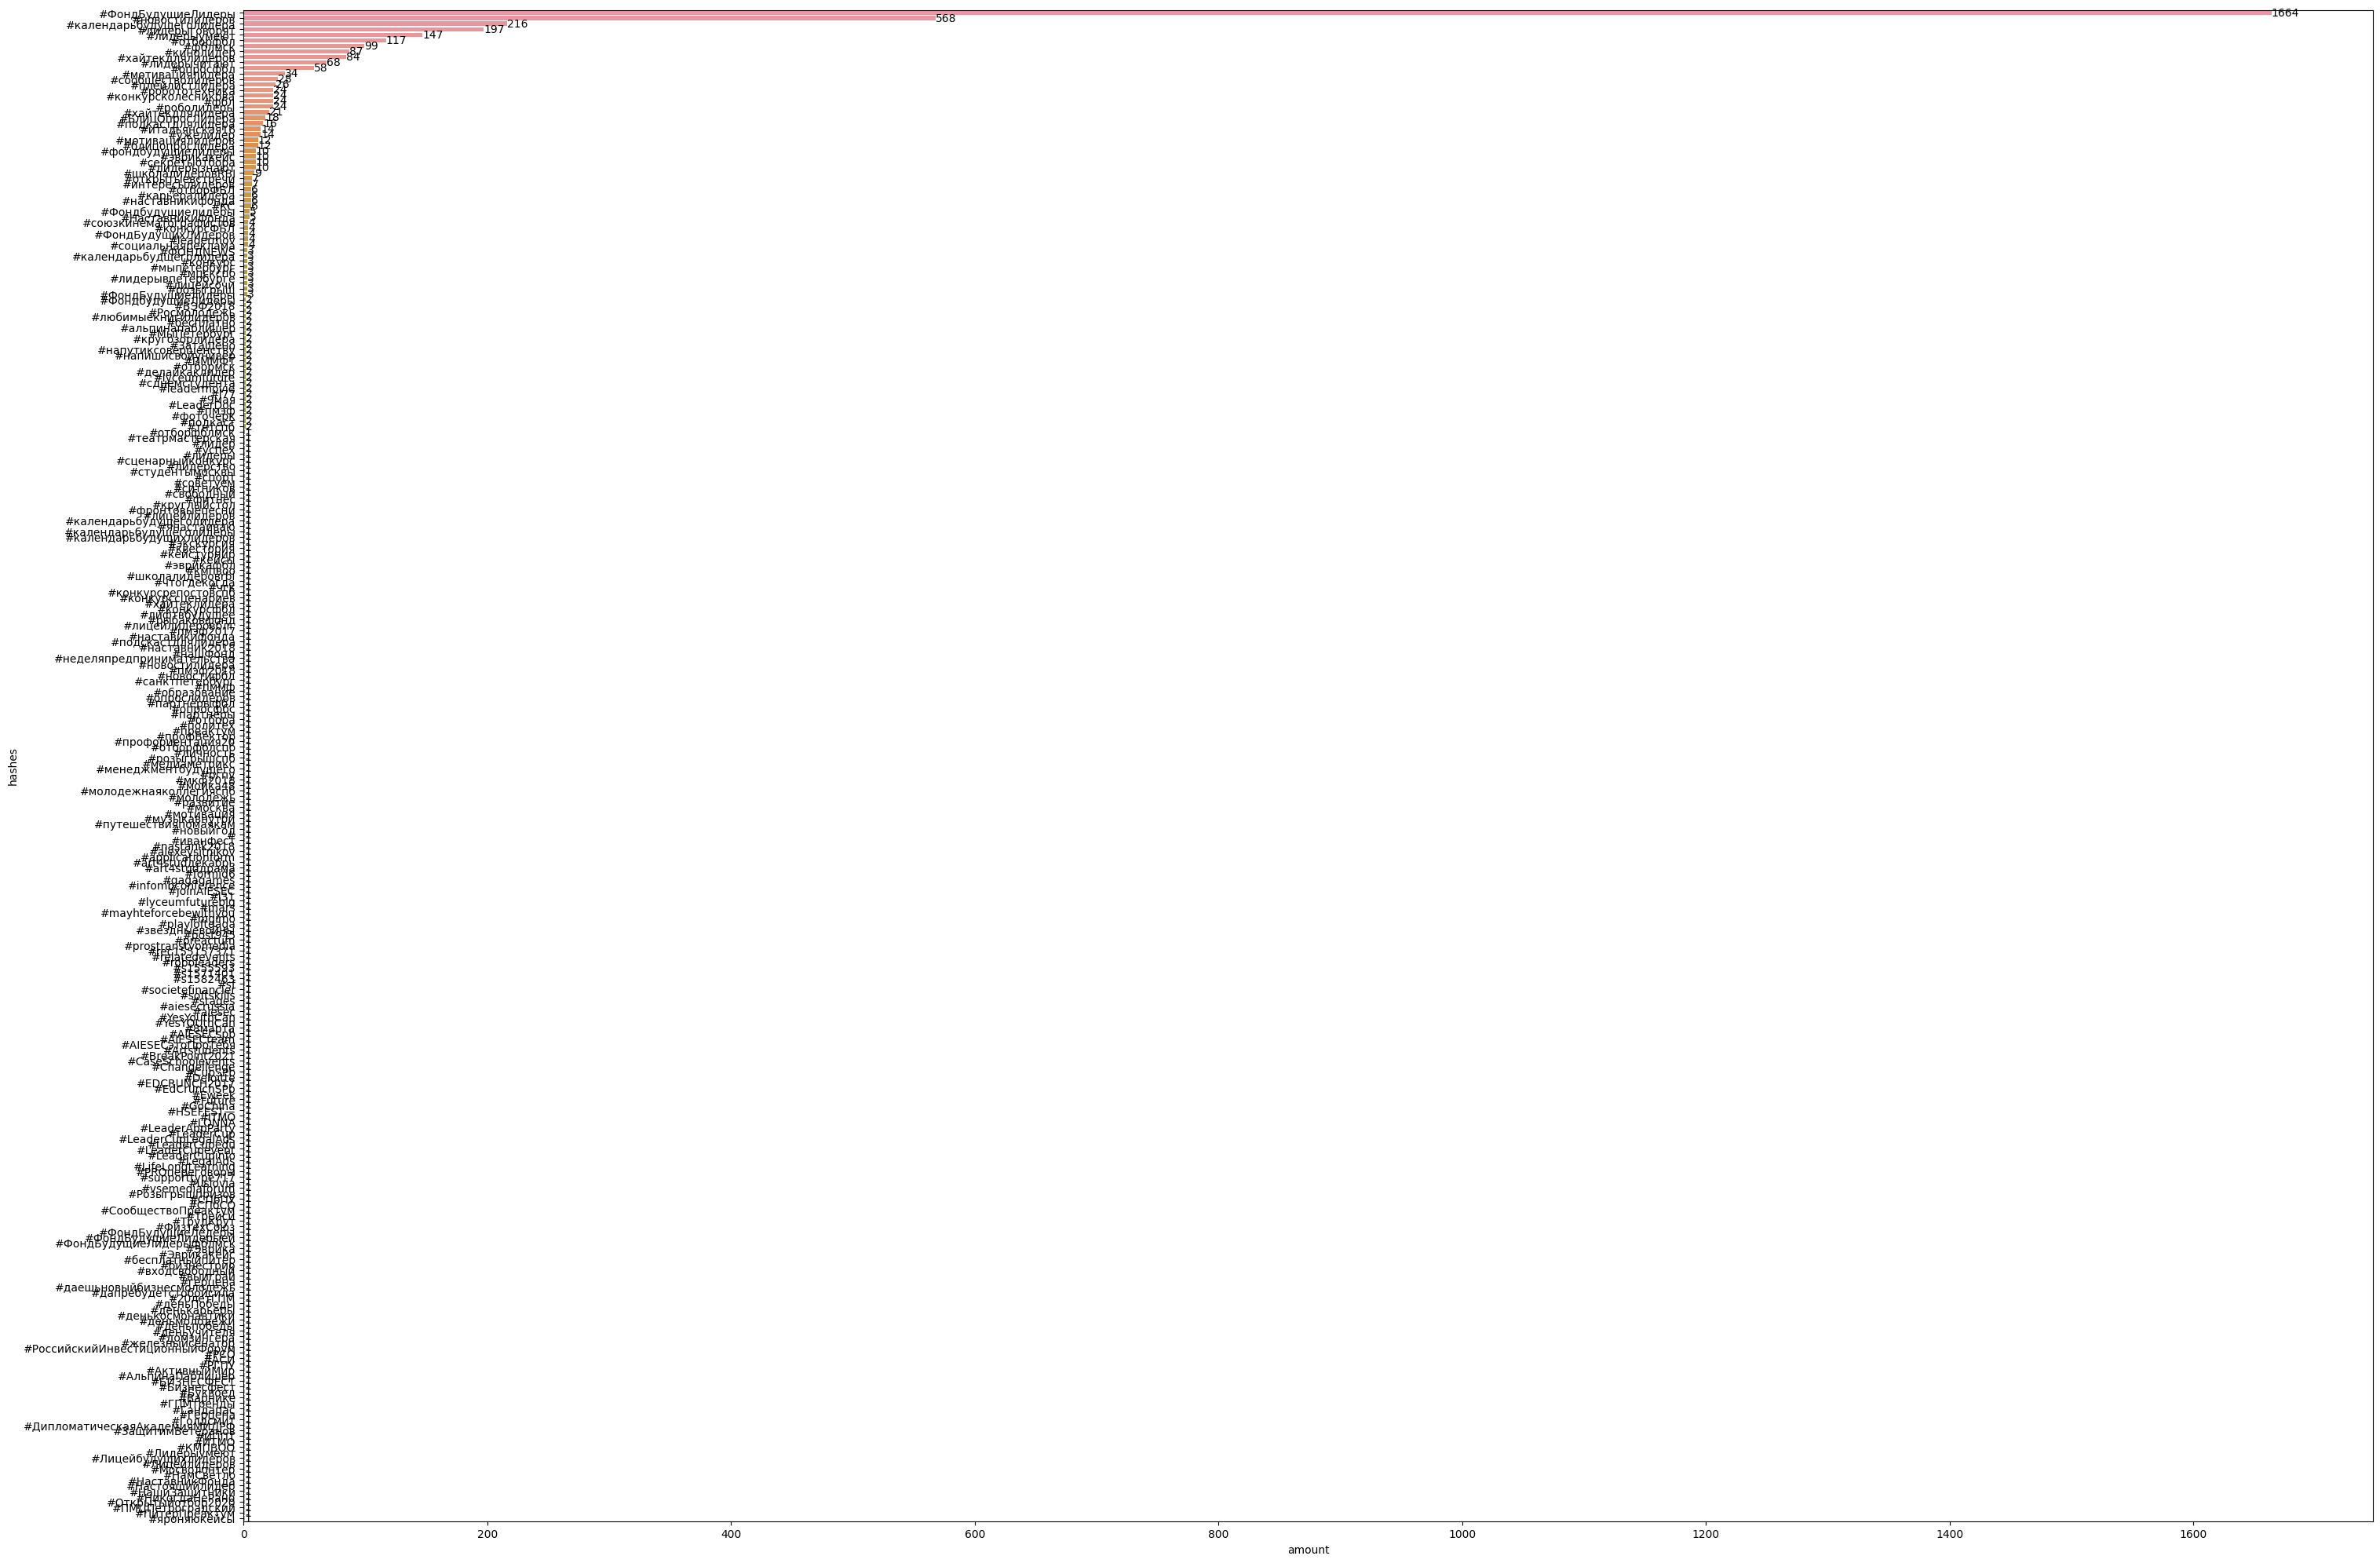

In [17]:
fig, ax = pyplot.subplots(figsize=(35, 25))                          # Задаём размер графика для хэштегов сообщества "Твой Ход"
sns.barplot(ax=ax, data=tvoyhod_hashes_values, x="amount", y="hashes")  # Строим столбчатую диаграмму с заданными параметрами
ax.bar_label(ax.containers[0], label_type='edge')                    # Применяем параметр для вывода количества хэштегов на график 

# ***Количество постов за каждый час***

In [18]:
def get_posts_time(group_id, domain, amount):                                                                                  # Параметры для запуска функции: ID группы, домен группы, нужное количество постов
  """Функция для получения времени публикации заданного количества постов из сообщества"""
  text_list = []                                                                                                               # Создаём пустой список, в который будем добавлять время публикации поста
  for offset in range(0, get_offset_wall(group_id, domain, amount)):                                                           # Создаём цикл для получения постов сообщества с помощью функции get_offset_wall
    params = {'access_token': vk_config["token"], 'owner_id': -1*group_id, 'domain': domain, 'offset': offset*20, 'v': 5.131}  # Параметры
    r = requests.get('https://api.vk.com/method/wall.get', params=params)                                                      # Запрос для получения постов сообщества 
    data = r.json()                                                                                                            # Переводим полученные результаты в формат json
    data = data['response']['items']                                                                                           # Обращаемся к полю "items", в котором хранится информация о постах
    for i in range(len(data)):                                                                                                 # Создаём цикл для работы с каждым отдельным постом
      if len(text_list) < amount:                                                                                              # Условие №1: если размер списка, созданного в строке 3, меньше двух тысяч,
        text_list.append(data[i]['date'])                                                                                      # то обращаемся к полю "date" и сохраняем дату публикации рассматриваемого поста
      else:                                                                                                                    # Условие №1: если же размер списка больше или равен 2000,
        break                                                                                                                  # то прерываем выполнение программы и переходим к следующей строке
  return text_list                                                                                                             # Функция возвращает список дат публикаций последних двух тысяч записей
  
rosmol_posts_date = get_posts_time(id_1, clubname_1, 2000)                                                                 # Используем функцию сбора дат публикаций постов для сообщества "Росмолодежь
tvoyhod_posts_date = get_posts_time(id_2, clubname_2, 2000)                                                               # Используем функцию сбора дат публикаций постов для сообщества "Твой Ход"

Количество постов: 2416
Количество постов: 2254


In [19]:
print(len(rosmol_posts_date))  # Проверка количества дат публикаций записей для сообщества "Росмолодежь"
print(len(tvoyhod_posts_date))   # Проверка количества дат публикаций записей для сообщества "Твой Ход"

2000
2000


In [20]:
def seconds_to_hours(list_name):                                                                    # Параметры для запуска функции: список с датами публикаций
  """Функция для перевода полученных дат публикаций в другой формат и извлечения значений часов"""
  for i in range(len(list_name)):                                                                   # Создаём цикл, который проходит по каждой дате публикации
    list_name[i] = int(datetime.datetime.fromtimestamp(list_name[i]).strftime('%H'))                # Переводим дату публикации в другой формат и забираем из неё значения часа
  return list_name                                                                                  # Функция возвращает изменённый список

rosmol_posts_hours = seconds_to_hours(rosmol_posts_date)                                              # Используем функцию извлечения значения часа для постов Росмолодежь "Маска"
tvoyhod_posts_hours = seconds_to_hours(tvoyhod_posts_date)                                                # Используем функцию извлечения значения часа для постов сообщества "Твой Ход"

In [21]:
rosmol_hours_df = pd.DataFrame({"hours": rosmol_posts_hours})  # Переделываем список часов публикаций постов сообщества "Росмолодежь" в датасет и называем новый столбец 'hours'
rosmol_hours_values = rosmol_hours_df.value_counts()           # Считаем количество вхождений каждого отдельного часа
rosmol_hours_values = pd.DataFrame(rosmol_hours_values)        # Переделываем полученный результат в датасет
rosmol_hours_values = rosmol_hours_values.reset_index()        # Сбрасываем индекс
rosmol_hours_values.columns.values[1] = "amount"              # Переименовываем столбец с количеством публикаций в определенный час в 'amount'

In [22]:
tvoyhod_hours_df = pd.DataFrame({"hours": tvoyhod_posts_hours})  # Переделываем список часов публикаций постов сообщества "Твой Ход" в датасет и называем новый столбец 'hours'
tvoyhod_hours_values = tvoyhod_hours_df.value_counts()           # Считаем количество вхождений каждого отдельного часа
tvoyhod_hours_values = pd.DataFrame(tvoyhod_hours_values)        # Переделываем полученный результат в датасет
tvoyhod_hours_values = tvoyhod_hours_values.reset_index()        # Сбрасываем индекс
tvoyhod_hours_values.columns.values[1] = "amount"             # Переименовываем столбец с количеством публикаций в определенный час в 'amount'

[Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '19'),
 Text(0, 0, '95'),
 Text(0, 0, '120'),
 Text(0, 0, '150'),
 Text(0, 0, '168'),
 Text(0, 0, '194'),
 Text(0, 0, '175'),
 Text(0, 0, '191'),
 Text(0, 0, '199'),
 Text(0, 0, '256'),
 Text(0, 0, '192'),
 Text(0, 0, '117'),
 Text(0, 0, '58'),
 Text(0, 0, '23'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '14'),
 Text(0, 0, '5'),
 Text(0, 0, '1')]

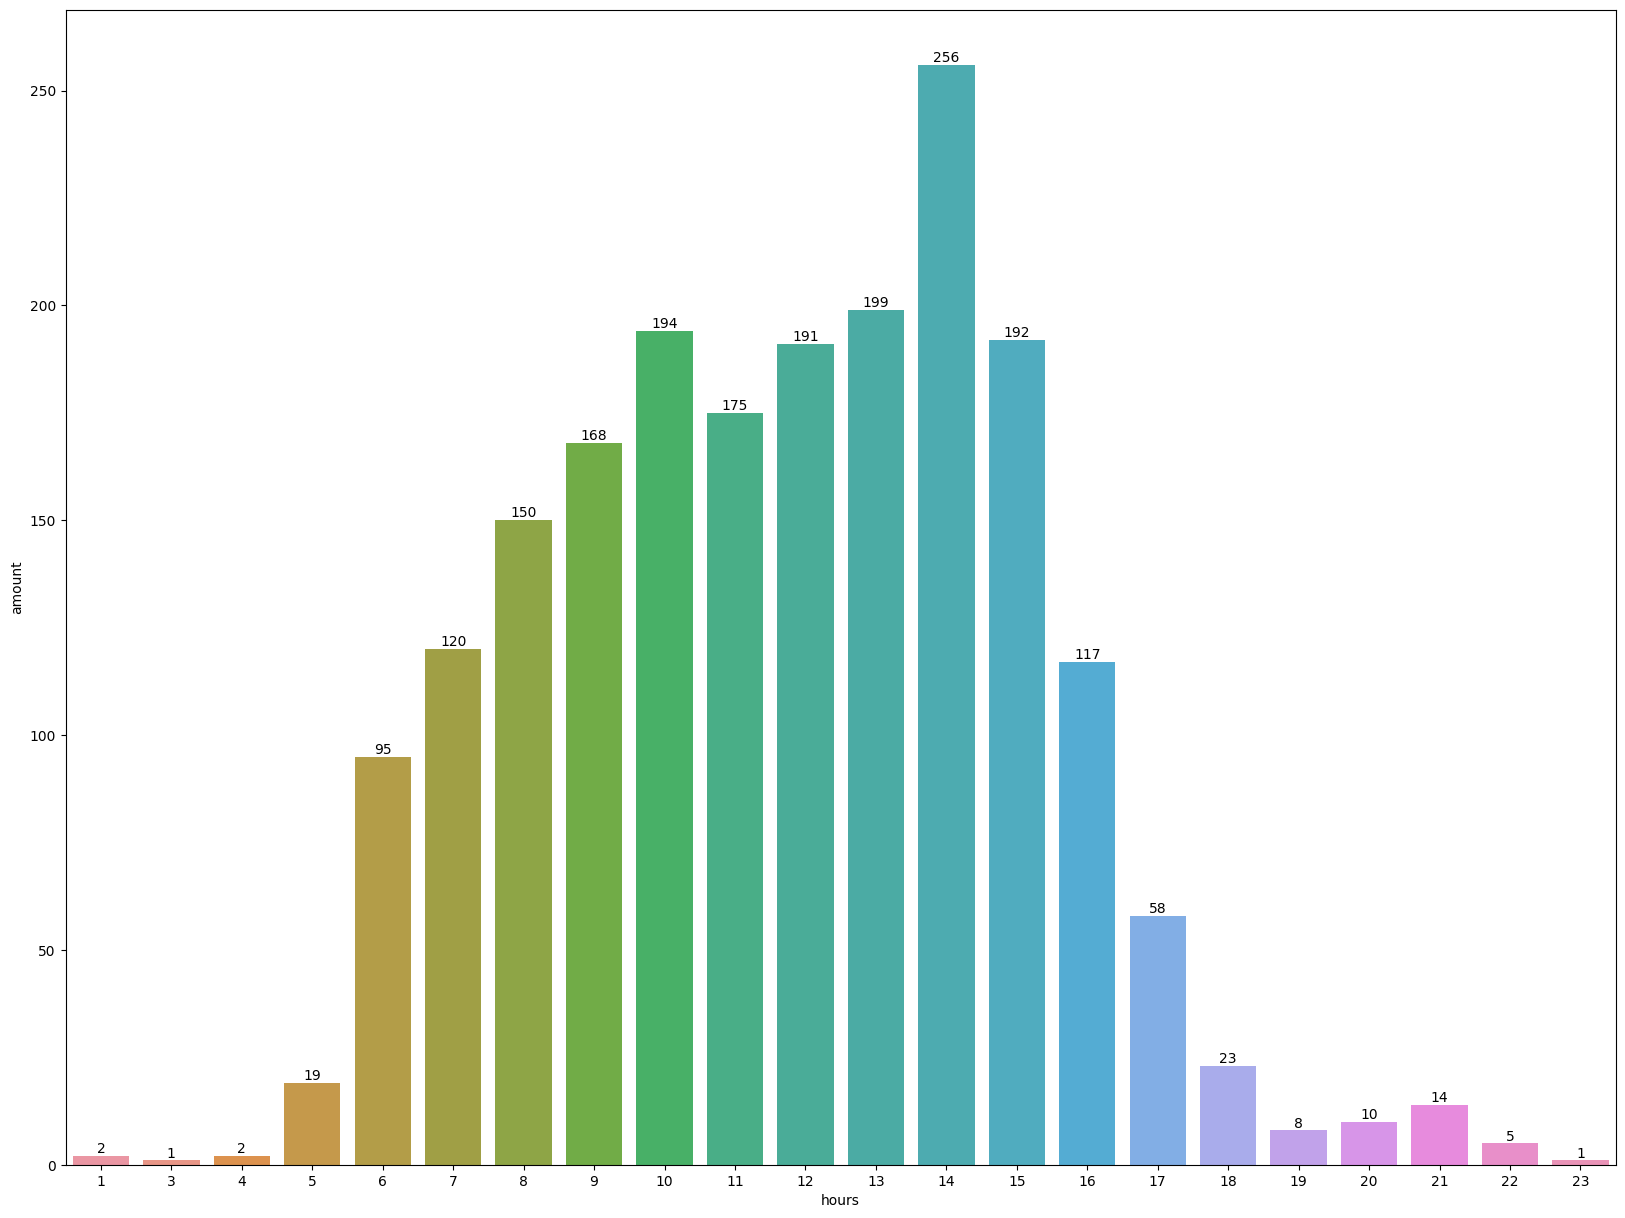

In [23]:
fig, ax = pyplot.subplots(figsize=(20, 15))                         # Задаём размер графика для часов публикаций постов сообщества "РМ"
sns.barplot(ax=ax, data=rosmol_hours_values, x="hours", y="amount")  # Строим столбчатую диаграмму с заданными параметрами
ax.bar_label(ax.containers[0], label_type='edge')                   # Применяем параметр для вывода количества хэштегов на график

[Text(0, 0, '2'),
 Text(0, 0, '24'),
 Text(0, 0, '79'),
 Text(0, 0, '102'),
 Text(0, 0, '148'),
 Text(0, 0, '90'),
 Text(0, 0, '102'),
 Text(0, 0, '123'),
 Text(0, 0, '137'),
 Text(0, 0, '197'),
 Text(0, 0, '358'),
 Text(0, 0, '178'),
 Text(0, 0, '165'),
 Text(0, 0, '96'),
 Text(0, 0, '174'),
 Text(0, 0, '20'),
 Text(0, 0, '4'),
 Text(0, 0, '1')]

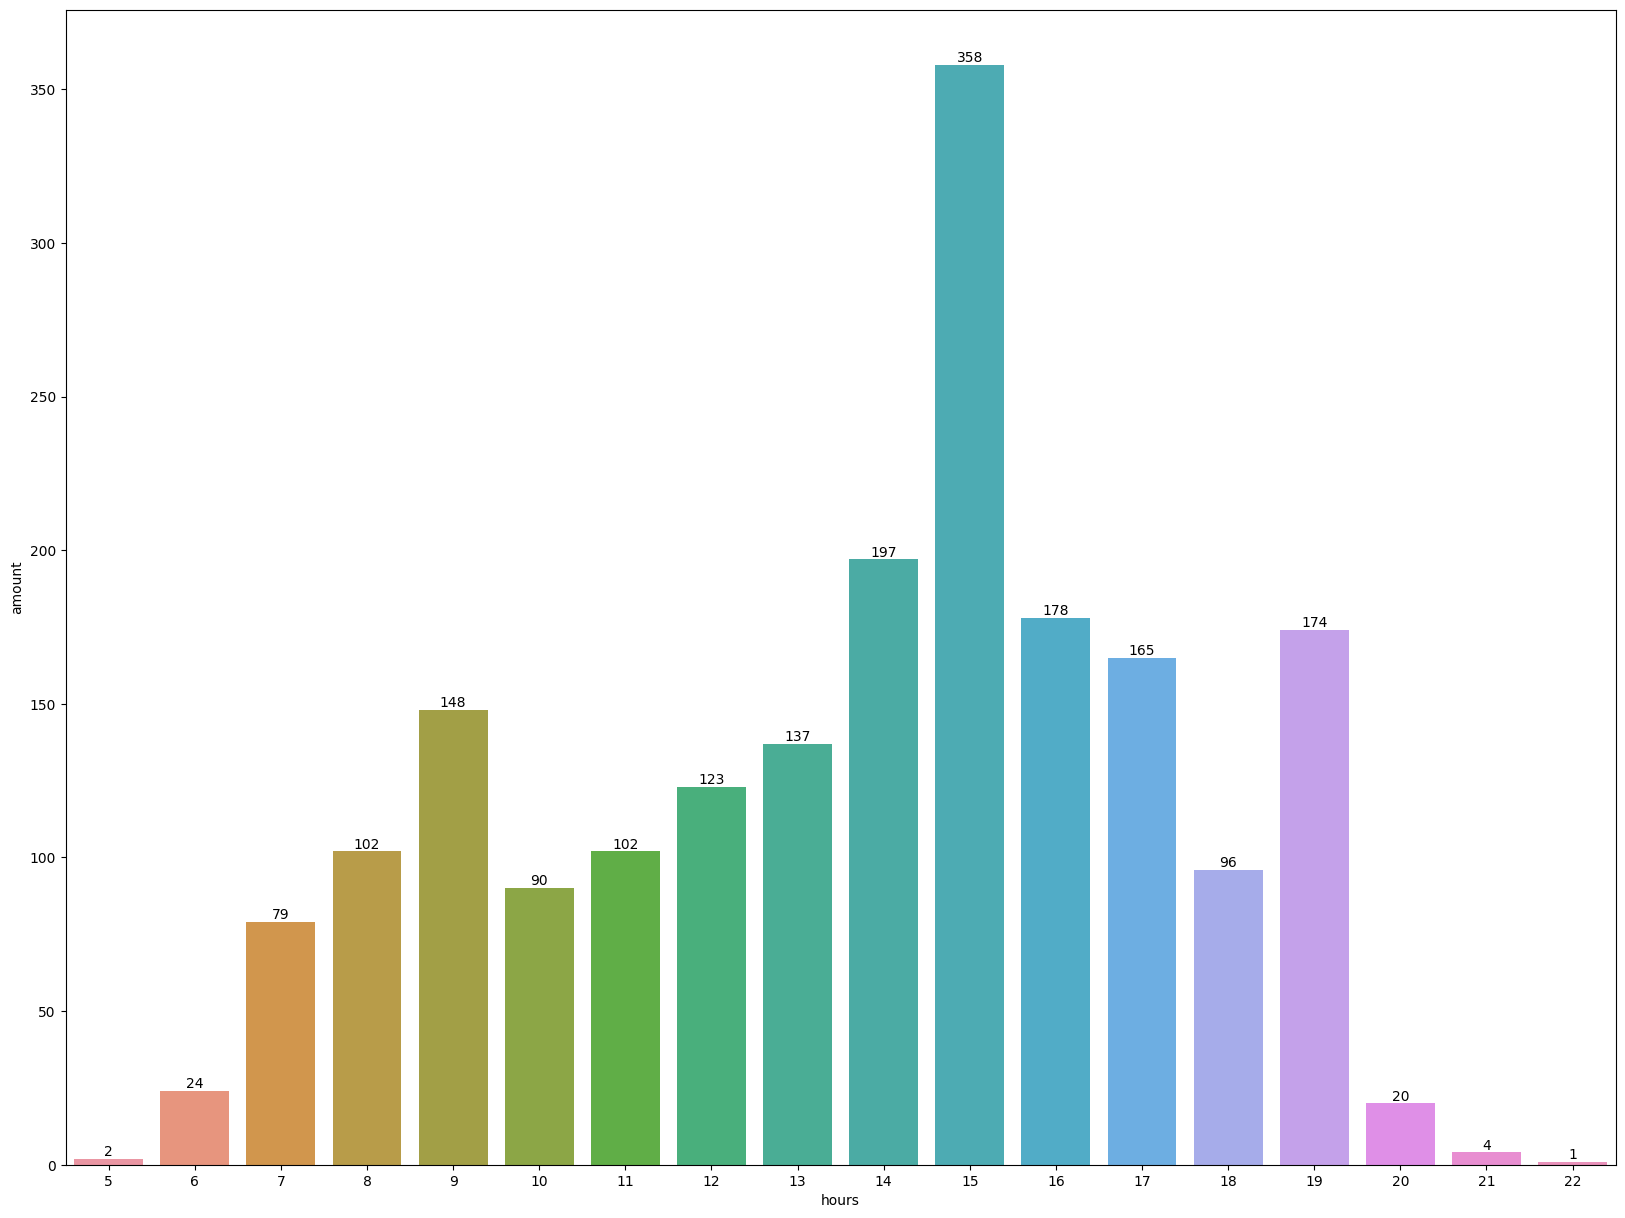

In [24]:
fig, ax = pyplot.subplots(figsize=(20, 15))                        # Задаём размер графика для часов публикаций постов сообщества "ТХ"
sns.barplot(ax=ax, data=tvoyhod_hours_values, x="hours", y="amount")  # Строим столбчатую диаграмму с заданными параметрами
ax.bar_label(ax.containers[0], label_type='edge')                  # Применяем параметр для вывода количества хэштегов на график

# ***Социальные графы***

## ***Социальный граф для пересечений обоих сообществ***

In [27]:
output = open('group_members.pkl', 'wb')    # Открываем файл
pickle.dump(common, output)                 # Загружаем в него ID людей, которые являются подписчиками обоих сообществ
output.close()                              # Закрываем файл

with open('group_members.pkl', 'rb') as f:  # Открываем файл ещё раз
    group_members = pickle.load(f)          # Выгружаем содержимое файла в список

In [28]:
members_ids = []                # Создаём пустой список, в который поместим ID людей, который являются подписчиками обоих сообществ
for member in group_members:    # Создаём цикл, который рассматривает каждого человека
    members_ids.append(member)  # Добавляем ID человека в новый список
len(members_ids)                # Проверяем длину списка

130

In [29]:
def get_friends(id):                                                                                          # Параметры для запуска функции: ID человека
  """Функция для проверки, находятся ли друзья человека в списке людей, которые вступили в оба сообщества"""
  text_list = []                                                                                              # Создаём пустой список, в который поместим ID друзей, которые вступили в оба сообщества
  params = {'access_token': vk_config["token"], 'user_id': id, 'v': 5.131}                                    # Параметры
  check = requests.get('https://api.vk.com/method/users.get', params=params)                                  # Запрос на получение информации о пользователе
  profile = check.json()["response"][0]["is_closed"]                                                          # Получения значения поля 'is_closed' для пользователя
  if profile == False:                                                                                        # Условие №1: если профиль человека открыт,
    data = requests.get('https://api.vk.com/method/friends.get', params=params).json()["response"]            # то посылаем запрос на получение списка его друзей
    items = data["items"]                                                                                     # Обращаемся к полю 'items', которое хранит информацию об ID друзей
    friends_inside_community_list = list(set(items).intersection(members_ids))                                # Проверяем полученные ID друзей на пересечение с теми людьми, которые вступили в оба сообщества
    return friends_inside_community_list                                                                      # Функция возвращает список с ID друзей пользователя, которые вступили в оба сообщества
  elif profile == True:                                                                                       # Условие №1: если же профиль человека скрыт,
    return []                                                                                                 # то функция возвращает пустой список

In [30]:
# Создаем файл, в нем список ребер: вершина - вершина 
f1 = open('friends.txt', 'w')     # Открываем файл для создания списка типа ID - ID для построения графа  
for member_id in members_ids:     # Создаём цикл, который рассматривает каждого человека
  a = get_friends(member_id)      # Используем функцию получению друзей для человека
  if len(a) != 0:                 # Условие №1: если длина списка не равна 0,
    for friend_id in a:           # то создаём цикл, который рассматривает каждый ID
      f1.write('%d' % member_id)  # Добавляем в файл ID пользователя, для которого выполнялась функция
      f1.write(' ')               # Пробел
      f1.write('%d' % friend_id)  # Добавляем в файл ID друга пользователя, если этот друг вступил в оба сообщества
      f1.write('\n')              # Новая строка
f1.close()                        # Закрываем файл

In [31]:
G = nx.read_edgelist('friends.txt', create_using=nx.DiGraph())                                                              # Создаём ориентированный социальный граф  
print('Количество вершин: {}'.format(G.number_of_nodes()))                                                                  # Выводим количество вершин графа
print('Количество рёбер: {}'.format(G.number_of_edges()))                                                                   # Выводим количество рёбер графа
print('Среднее количество соседей у узлов в графе: {}'.format(round(G.number_of_edges() / float(G.number_of_nodes()), 4)))  # Выводим среднее количество соседей у вершин в графе

Количество вершин: 67
Количество рёбер: 139
Среднее количество соседей у узлов в графе: 2.0746


In [32]:
G1 = nx.read_edgelist('friends.txt')                                                                                          # Создаём неориентированный социальный граф  
print('Количество вершин: {}'.format(G1.number_of_nodes()))                                                                   # Выводим количество вершин графа
print('Количество рёбер: {}'.format(G1.number_of_edges()))                                                                    # Выводим количество рёбер графа
print('Среднее количество соседей у узлов в графе: {}'.format(round(G1.number_of_edges() / float(G1.number_of_nodes()), 4)))  # Выводим среднее количество соседей у вершин в графе

Количество вершин: 67
Количество рёбер: 79
Среднее количество соседей у узлов в графе: 1.1791


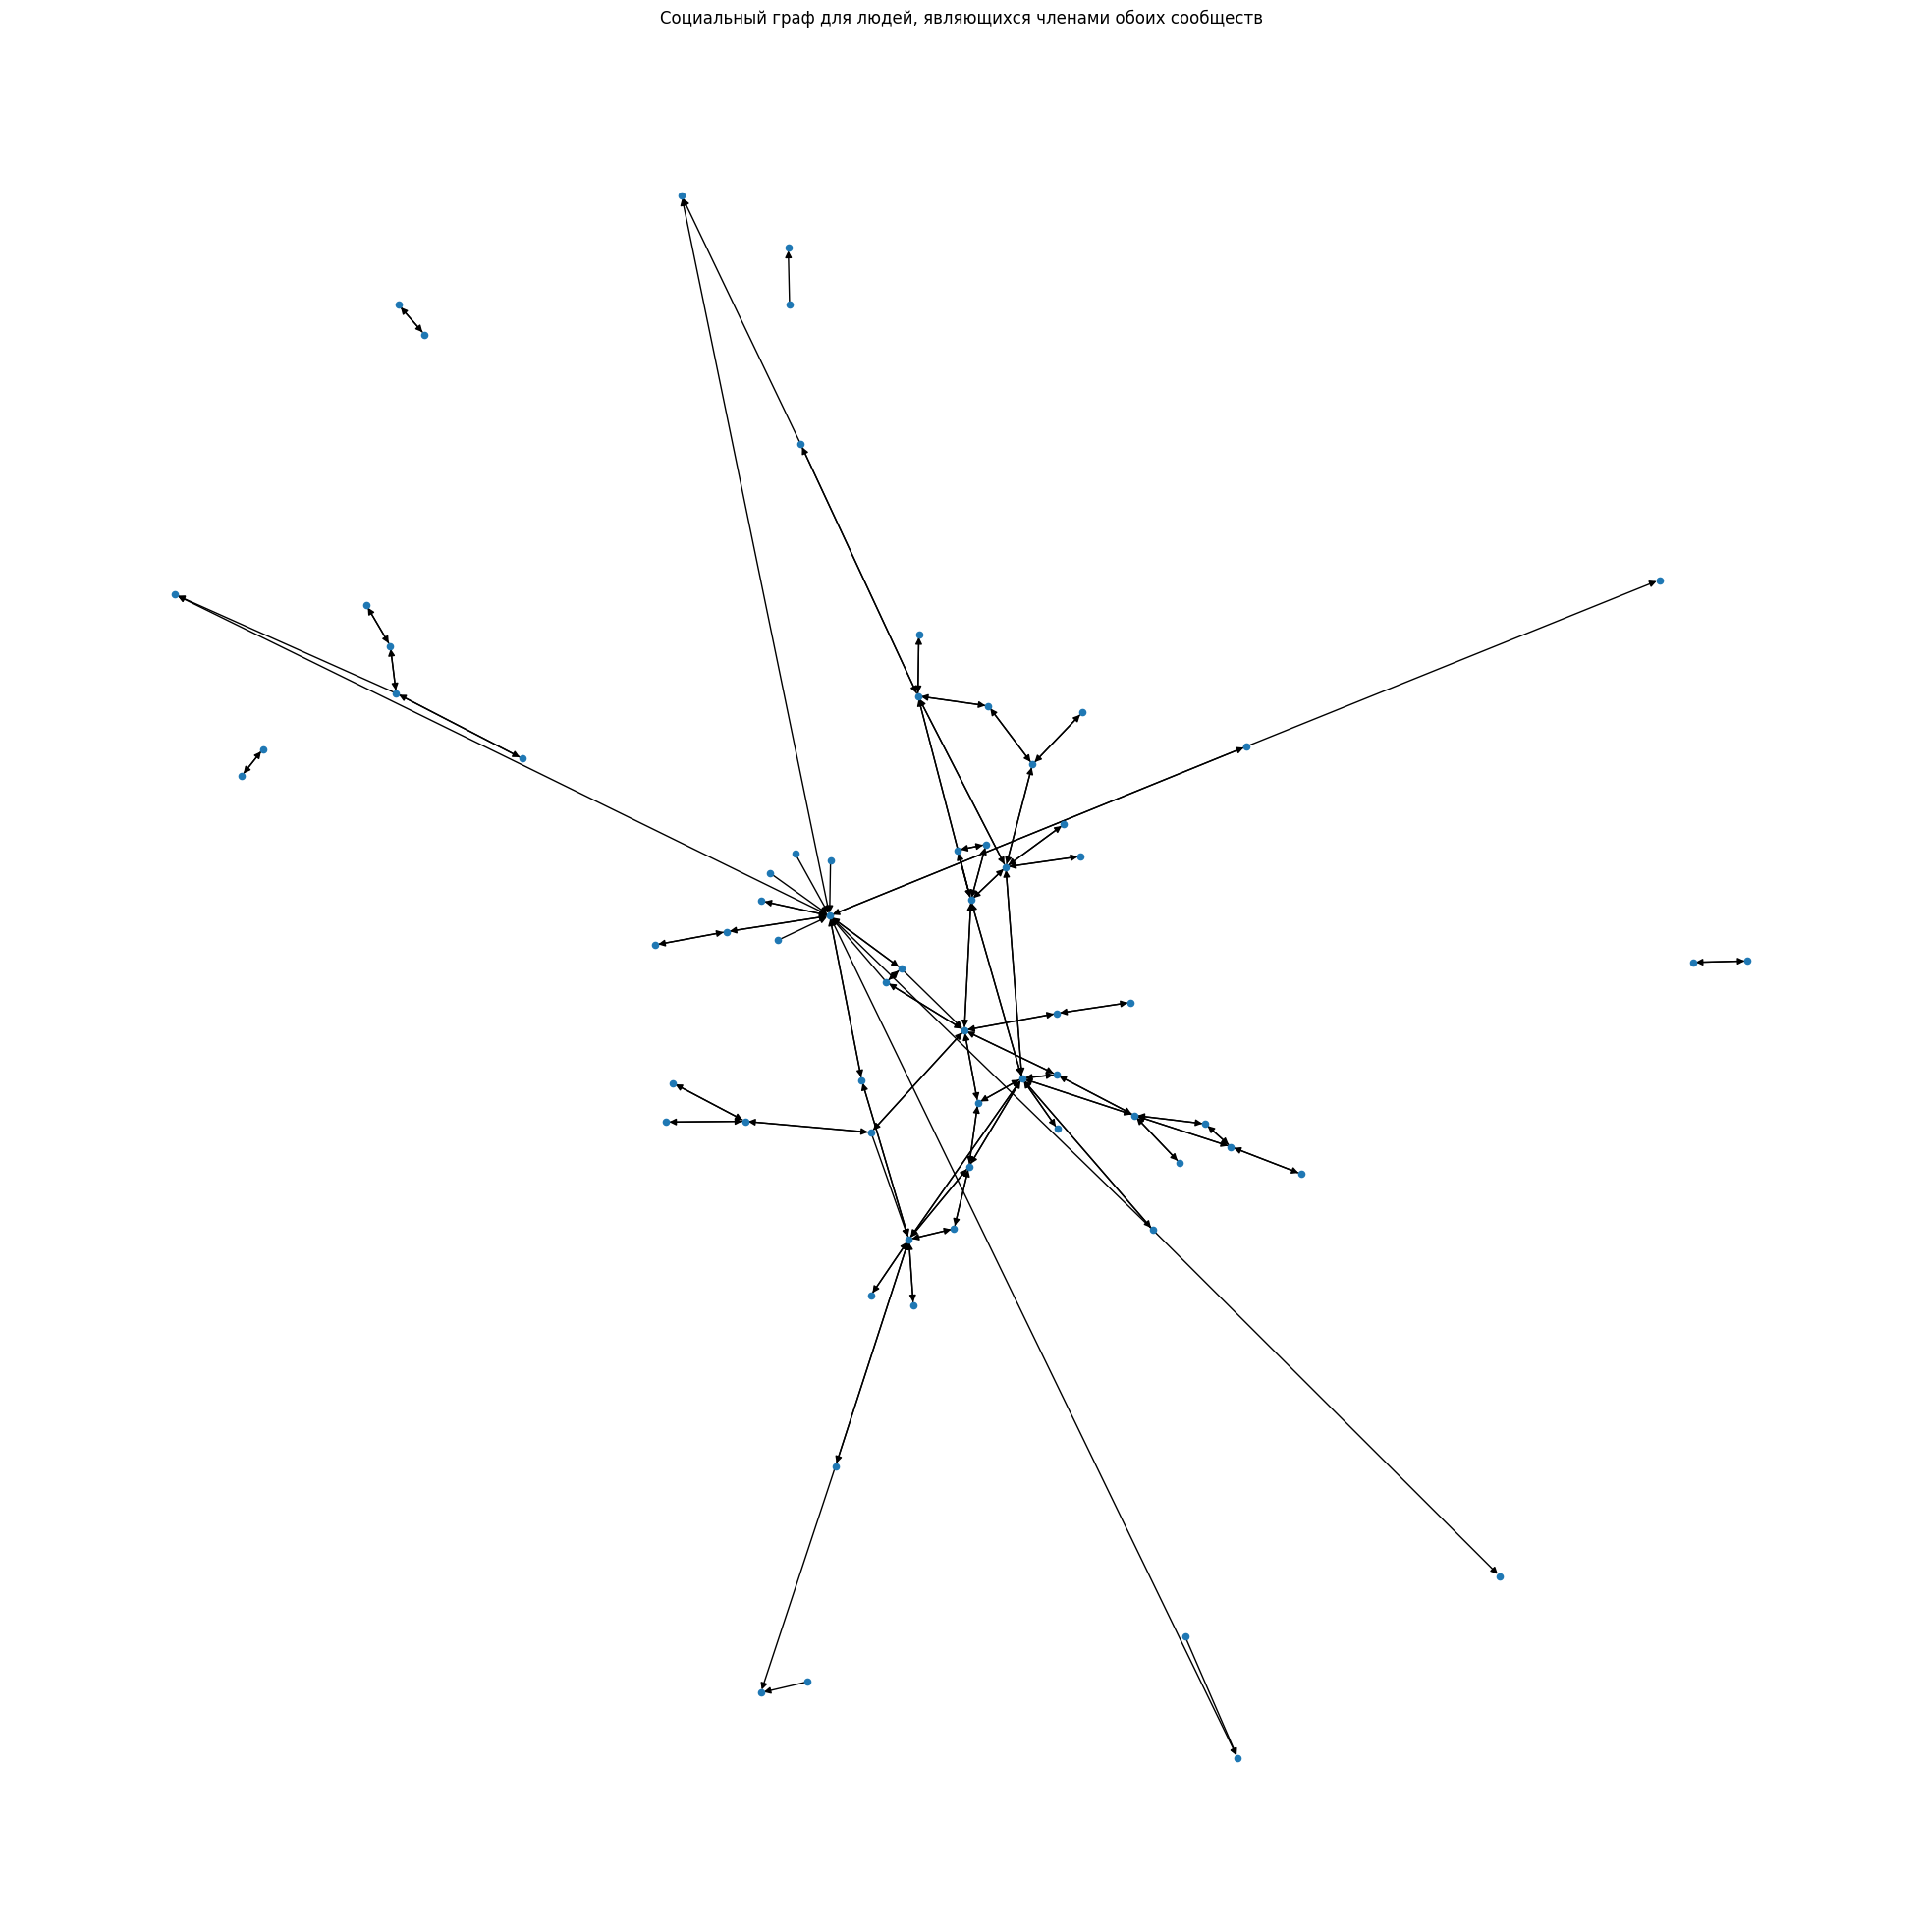

In [33]:
plt.figure(figsize=(25, 25))                                                # Задаём размер графика для ориентированного социального графа
plt.title('Социальный граф для людей, являющихся членами обоих сообществ')  # Даём графику название
nx.draw(G, node_size=20)                                                    # Отрисовываем граф с размером вершины = 20
plt.show()                                                                  # Выводим граф

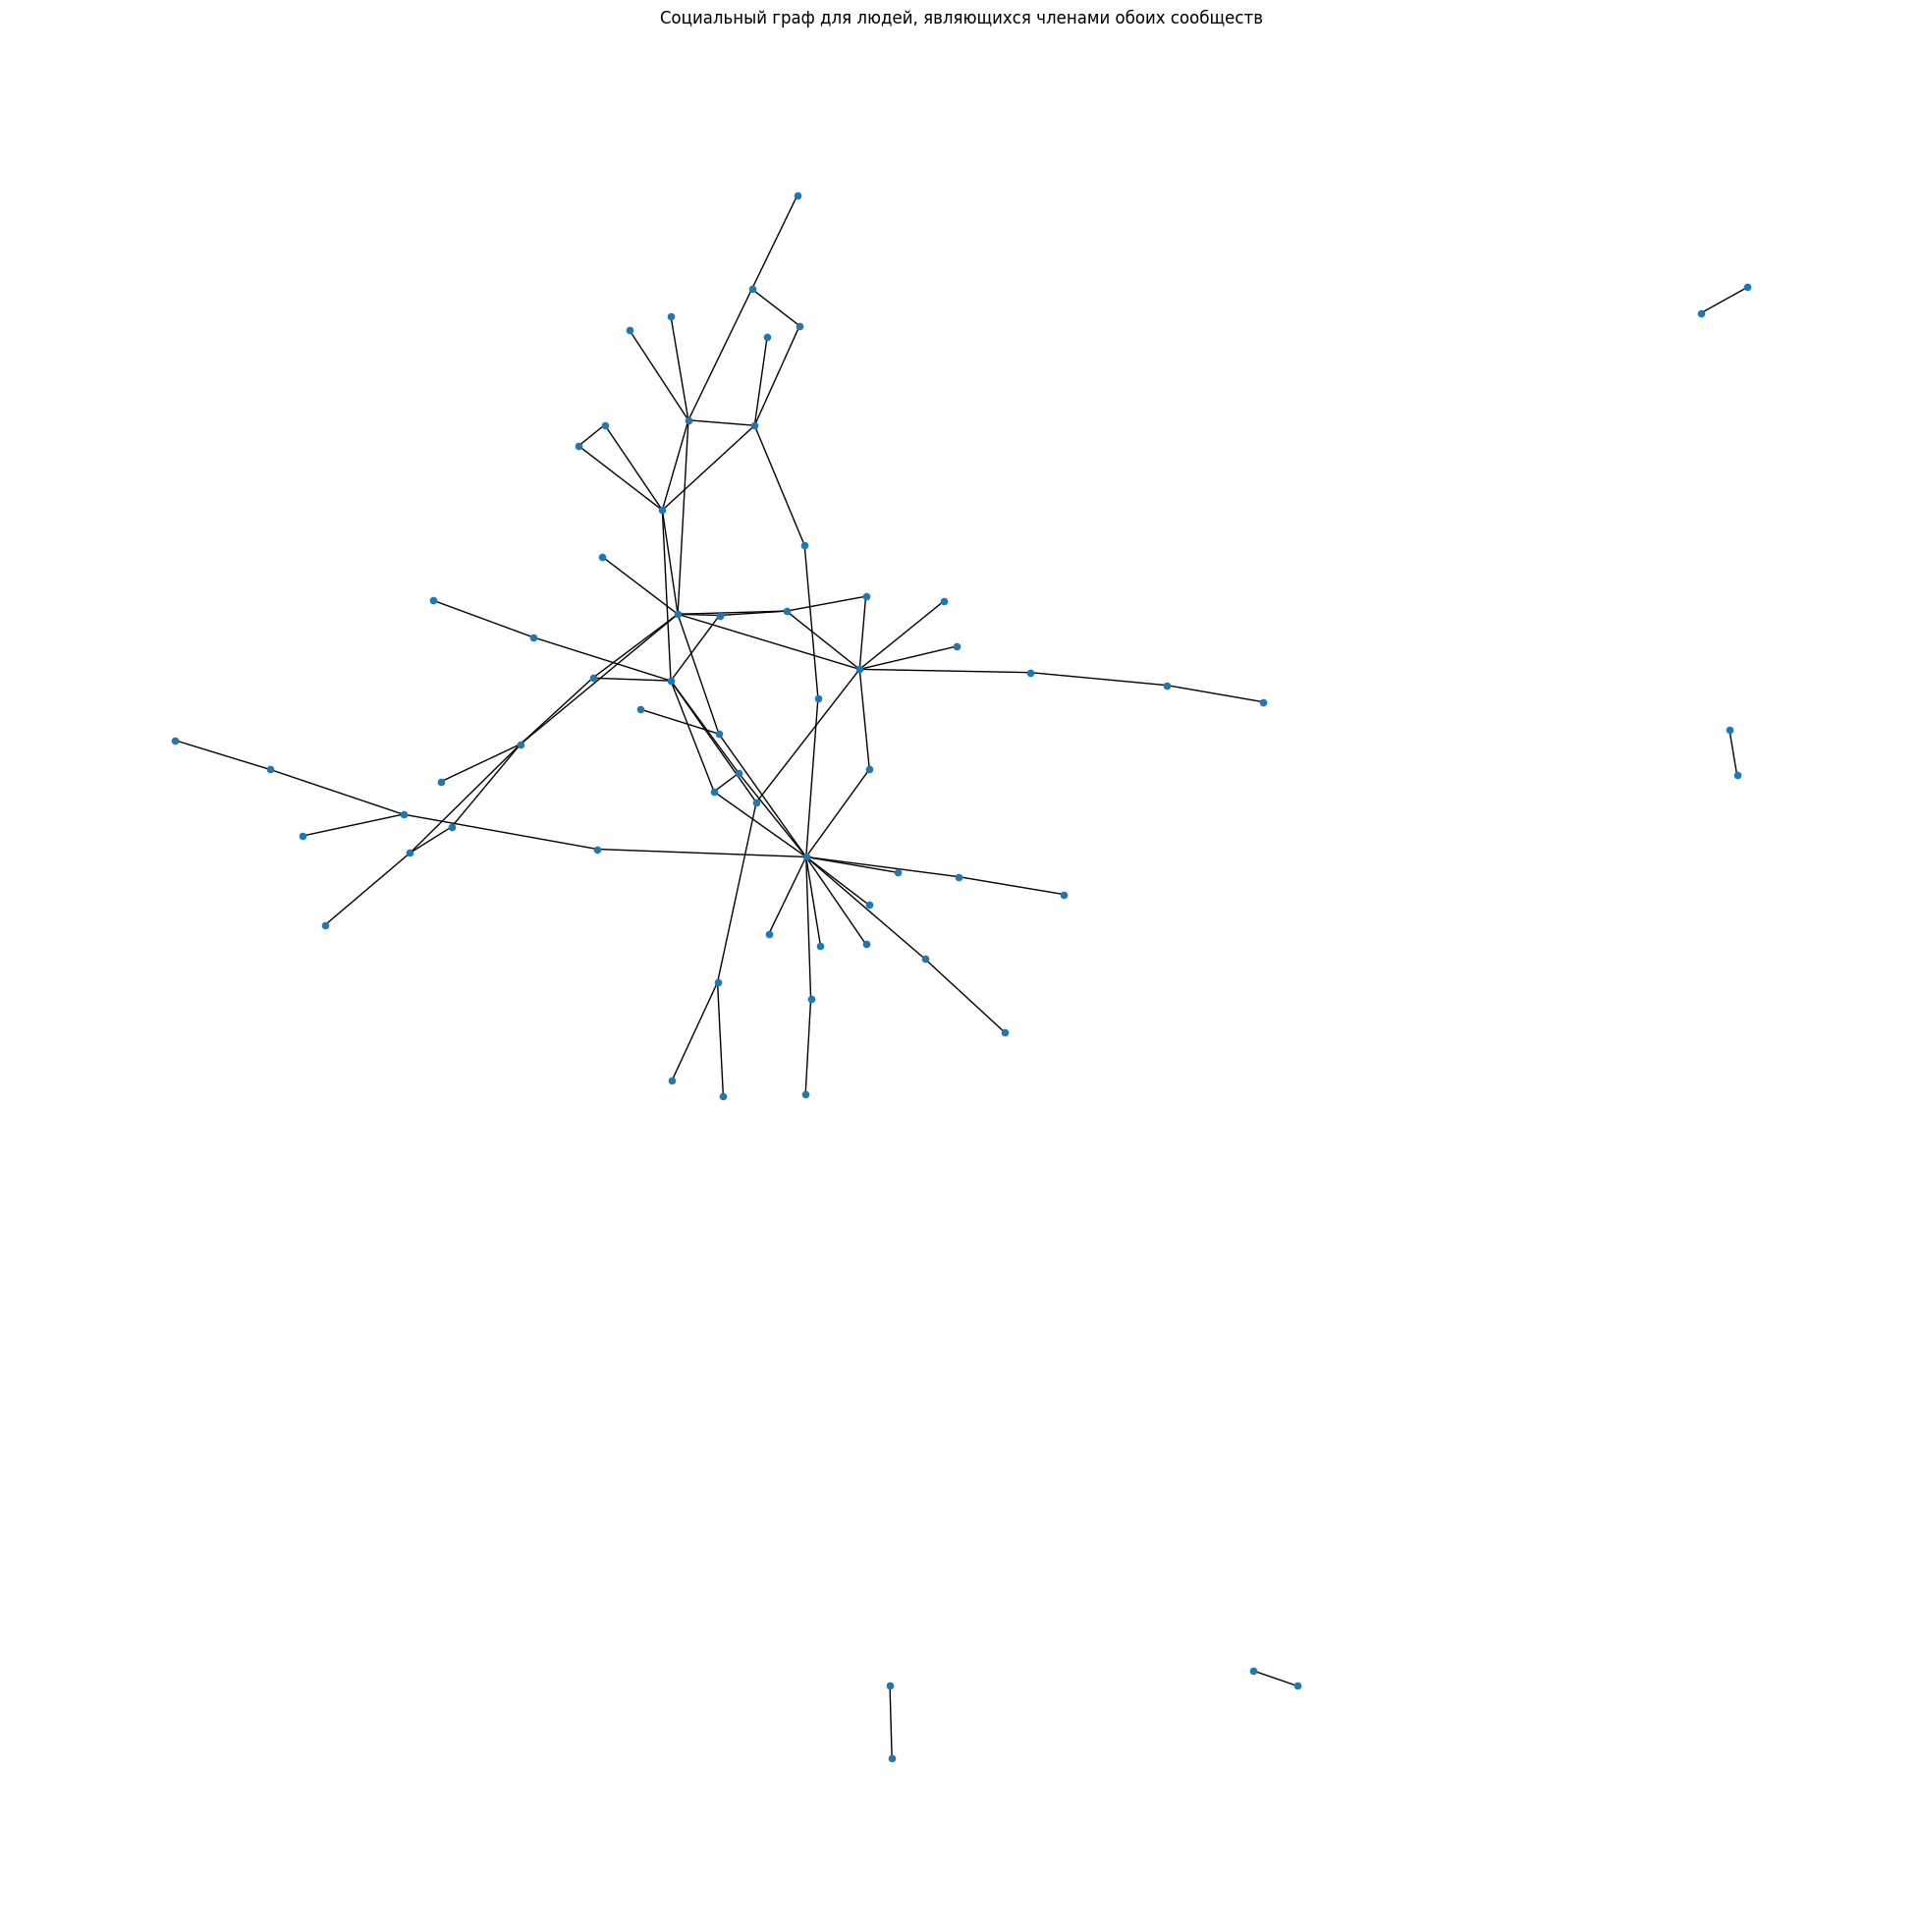

In [34]:
plt.figure(figsize=(25, 25))                                                # Задаём размер графика для неориентированного социального графа
plt.title('Социальный граф для людей, являющихся членами обоих сообществ')  # Даём графику название
nx.draw(G1, node_size=20)                                                   # Отрисовываем граф с размером вершины = 20
plt.show()                                                                  # Выводим граф

## ***Социальный граф для сообщества "БФ Система"***

In [35]:
rosmol_users = []
rosmol100 = rosmol[0:100]
for i in range(len(rosmol100)):
  # print(i)
  a = len(get_friends(rosmol100[i]))
  if a != 0:
    rosmol_users.append([rosmol100[i], a])
rosmol_users

[[75791, 3],
 [96163, 1],
 [143764, 1],
 [227014, 5],
 [287607, 1],
 [326011, 1],
 [425998, 2],
 [506552, 1],
 [531716, 2],
 [641894, 6]]

In [36]:
random_rosmol = list(np.random.choice(rosmol, size=1000, replace=False))
f2 = open(clubname_1+'.txt', 'w')
i = 0
for member_id in random_rosmol:
  #print(i)
  a = get_friends(member_id)   
  if len(a) != 0:  
    for friend_id in a:
      f2.write('%d' % member_id)
      f2.write(' ')
      f2.write('%d' % friend_id)
      f2.write('\n')
  i += 1
f2.close()

In [37]:
G2 = nx.read_edgelist(clubname_1+'.txt', create_using=nx.DiGraph())
print('Количество вершин: {}'.format(G2.number_of_nodes()))
print('Количество рёбер: {}'.format(G2.number_of_edges()))
print('Среднее количество соседей у узлов в графе: {}'.format(round(G2.number_of_edges() / float(G2.number_of_nodes()), 4)))

Количество вершин: 117
Количество рёбер: 140
Среднее количество соседей у узлов в графе: 1.1966


In [38]:
G2_1 = nx.read_edgelist(clubname_1 + '.txt')
print('Количество вершин: {}'.format(G2_1.number_of_nodes()))
print('Количество рёбер: {}'.format(G2_1.number_of_edges()))
print('Среднее количество соседей у узлов в графе: {}'.format(round(G2_1.number_of_edges() / float(G2_1.number_of_nodes()), 4)))

Количество вершин: 117
Количество рёбер: 140
Среднее количество соседей у узлов в графе: 1.1966


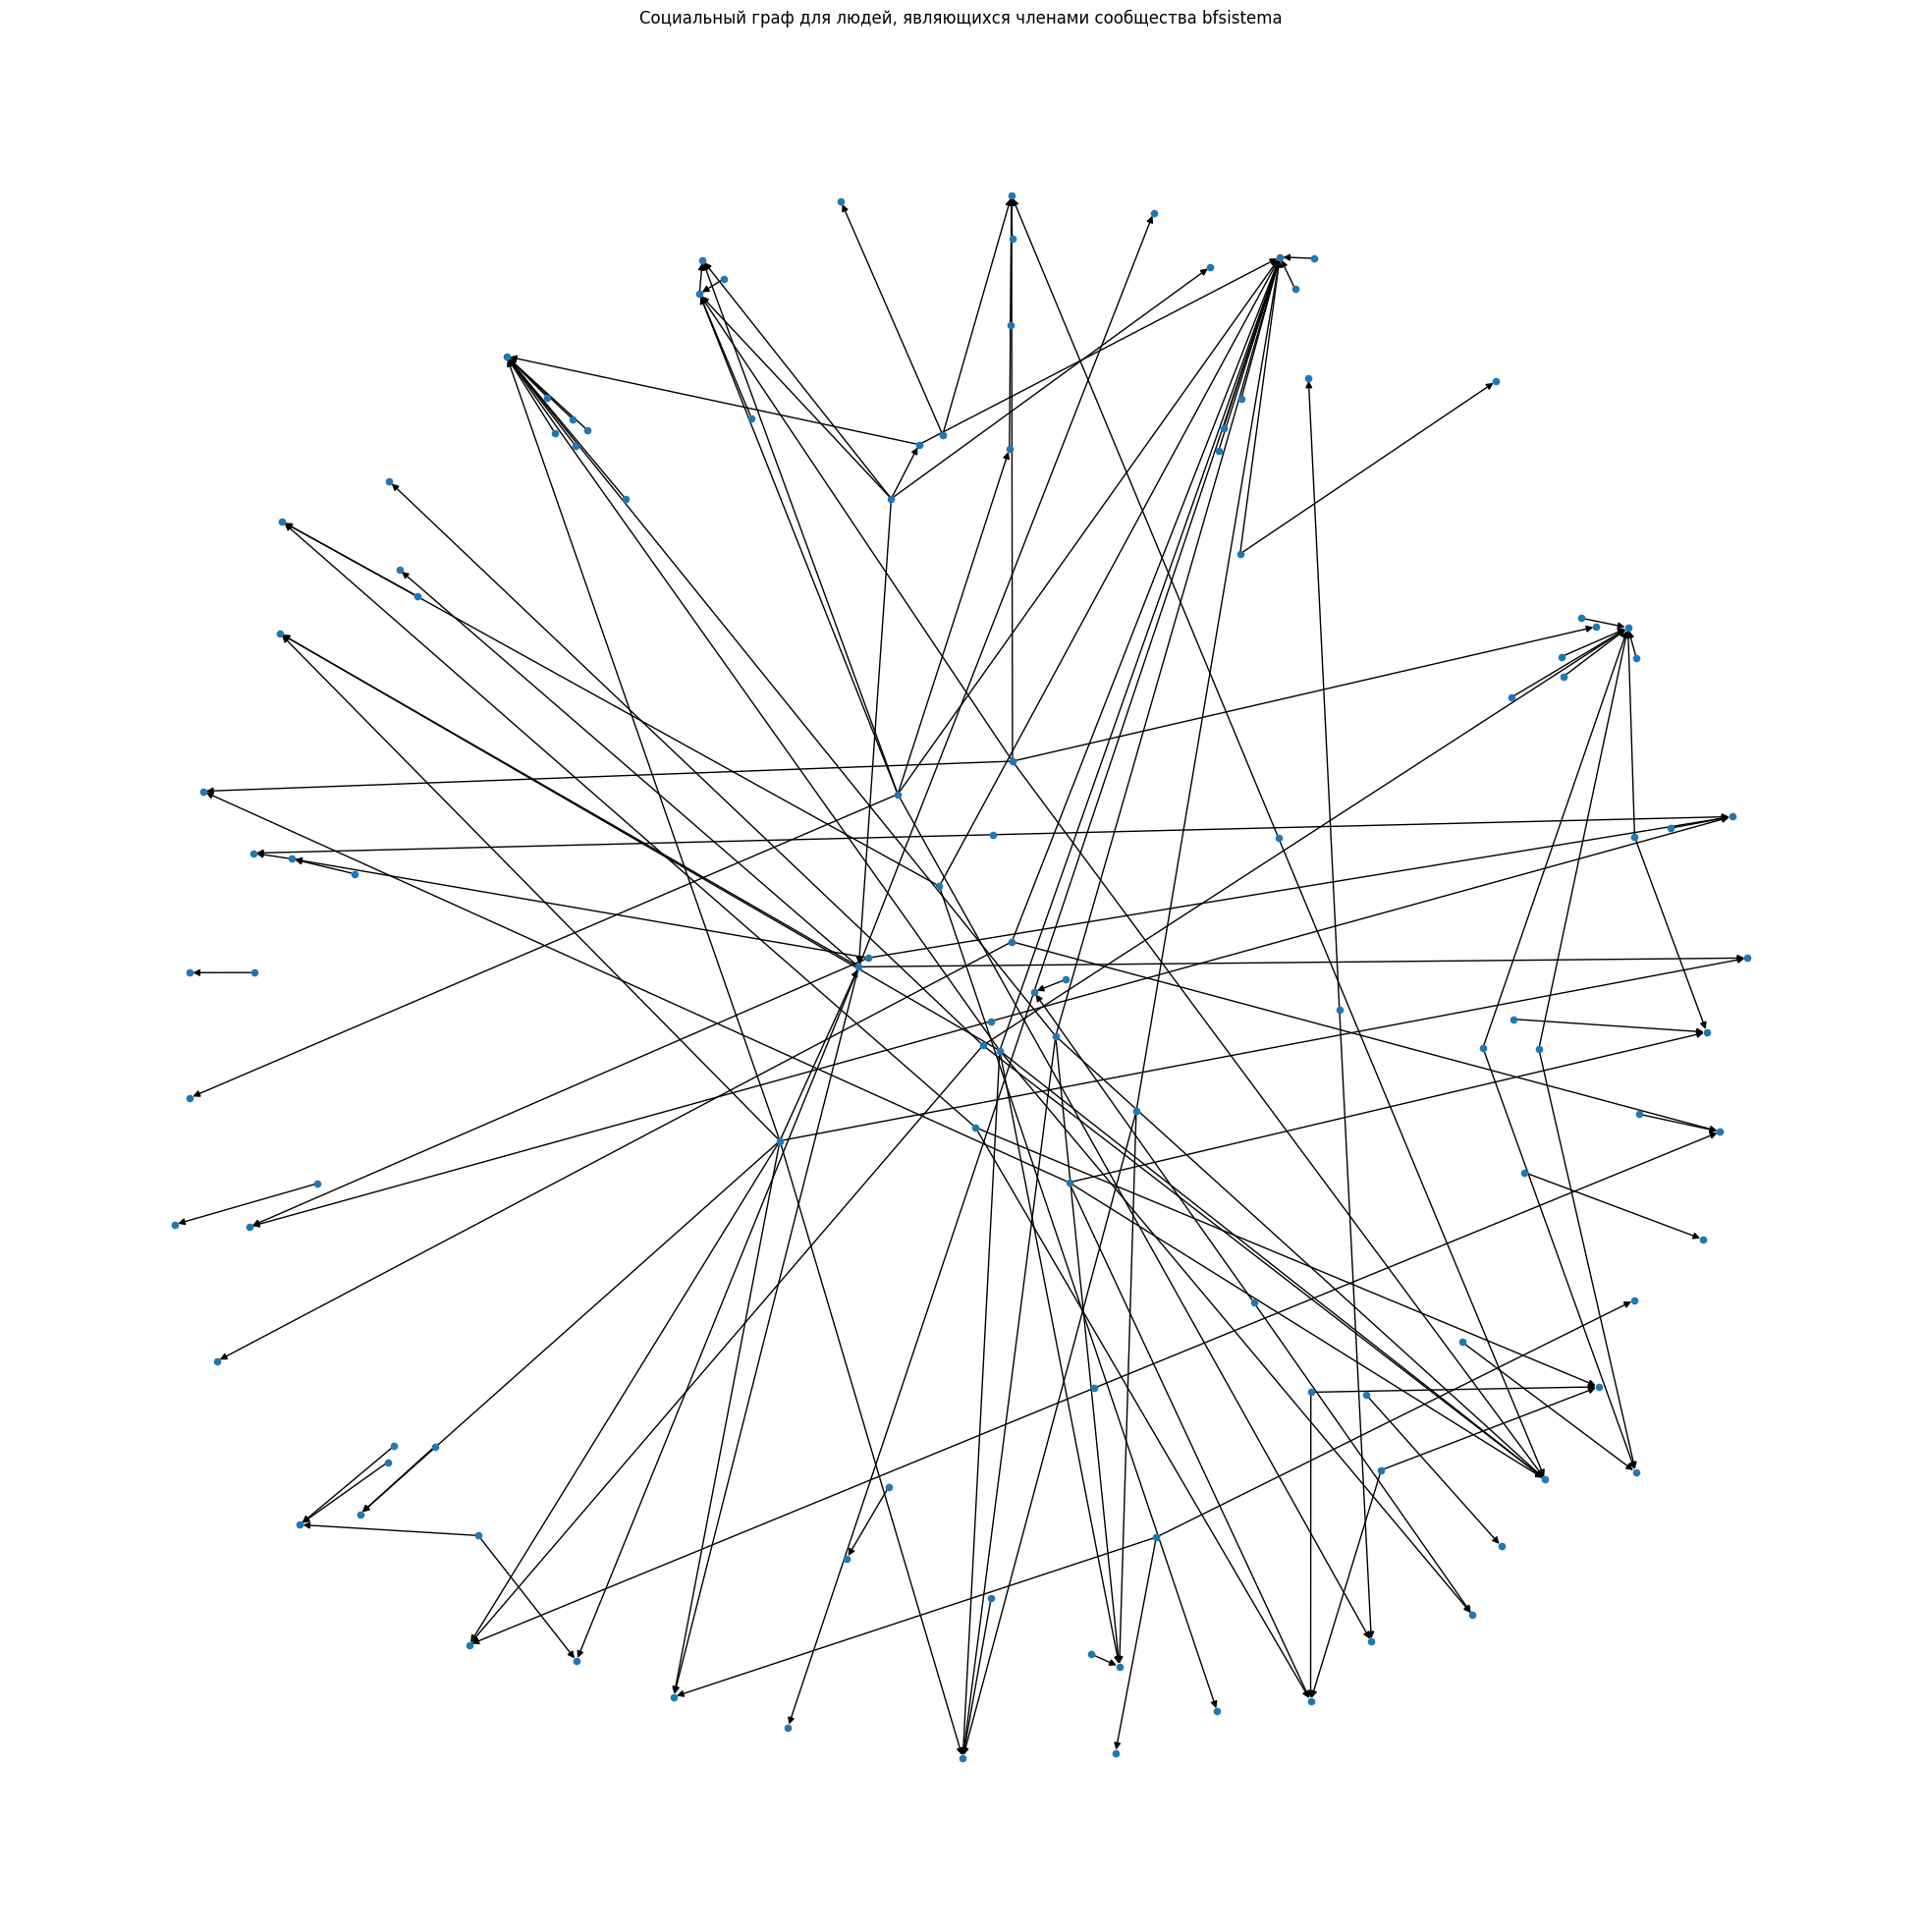

In [39]:
plt.figure(figsize=(25, 25))
plt.title('Социальный граф для людей, являющихся членами сообщества ' + clubname_1)
nx.draw(G2, node_size=20)
plt.show()

## ***Социальный граф для сообщества "Фонд Будущие Лидеры"***

In [40]:
random_tvoyhod = list(np.random.choice(tvoyhod, size=500, replace=False))
#print(random_euro)
f3 = open(clubname_2 + '.txt', 'w')
i = 0
for member_id in random_tvoyhod:
  #print(i)
  a = get_friends(member_id)   
  if len(a) != 0:  
    for friend_id in a:
      f3.write('%d' % member_id)
      f3.write(' ')
      f3.write('%d' % friend_id)
      f3.write('\n')
  i += 1
f3.close()

In [41]:
G3 = nx.read_edgelist(clubname_2 + '.txt', create_using=nx.DiGraph())
print('Количество вершин: {}'.format(G3.number_of_nodes()))
print('Количество рёбер: {}'.format(G3.number_of_edges()))
print('Среднее количество соседей у узлов в графе: {}'.format(round(G3.number_of_edges() / float(G3.number_of_nodes()), 4)))

Количество вершин: 86
Количество рёбер: 67
Среднее количество соседей у узлов в графе: 0.7791


In [42]:
G3_1 = nx.read_edgelist(clubname_2+'.txt')
print('Количество вершин: {}'.format(G3_1.number_of_nodes()))
print('Количество рёбер: {}'.format(G3_1.number_of_edges()))
print('Среднее количество соседей у узлов в графе: {}'.format(round(G3_1.number_of_edges() / float(G3_1.number_of_nodes()), 4)))

Количество вершин: 86
Количество рёбер: 67
Среднее количество соседей у узлов в графе: 0.7791


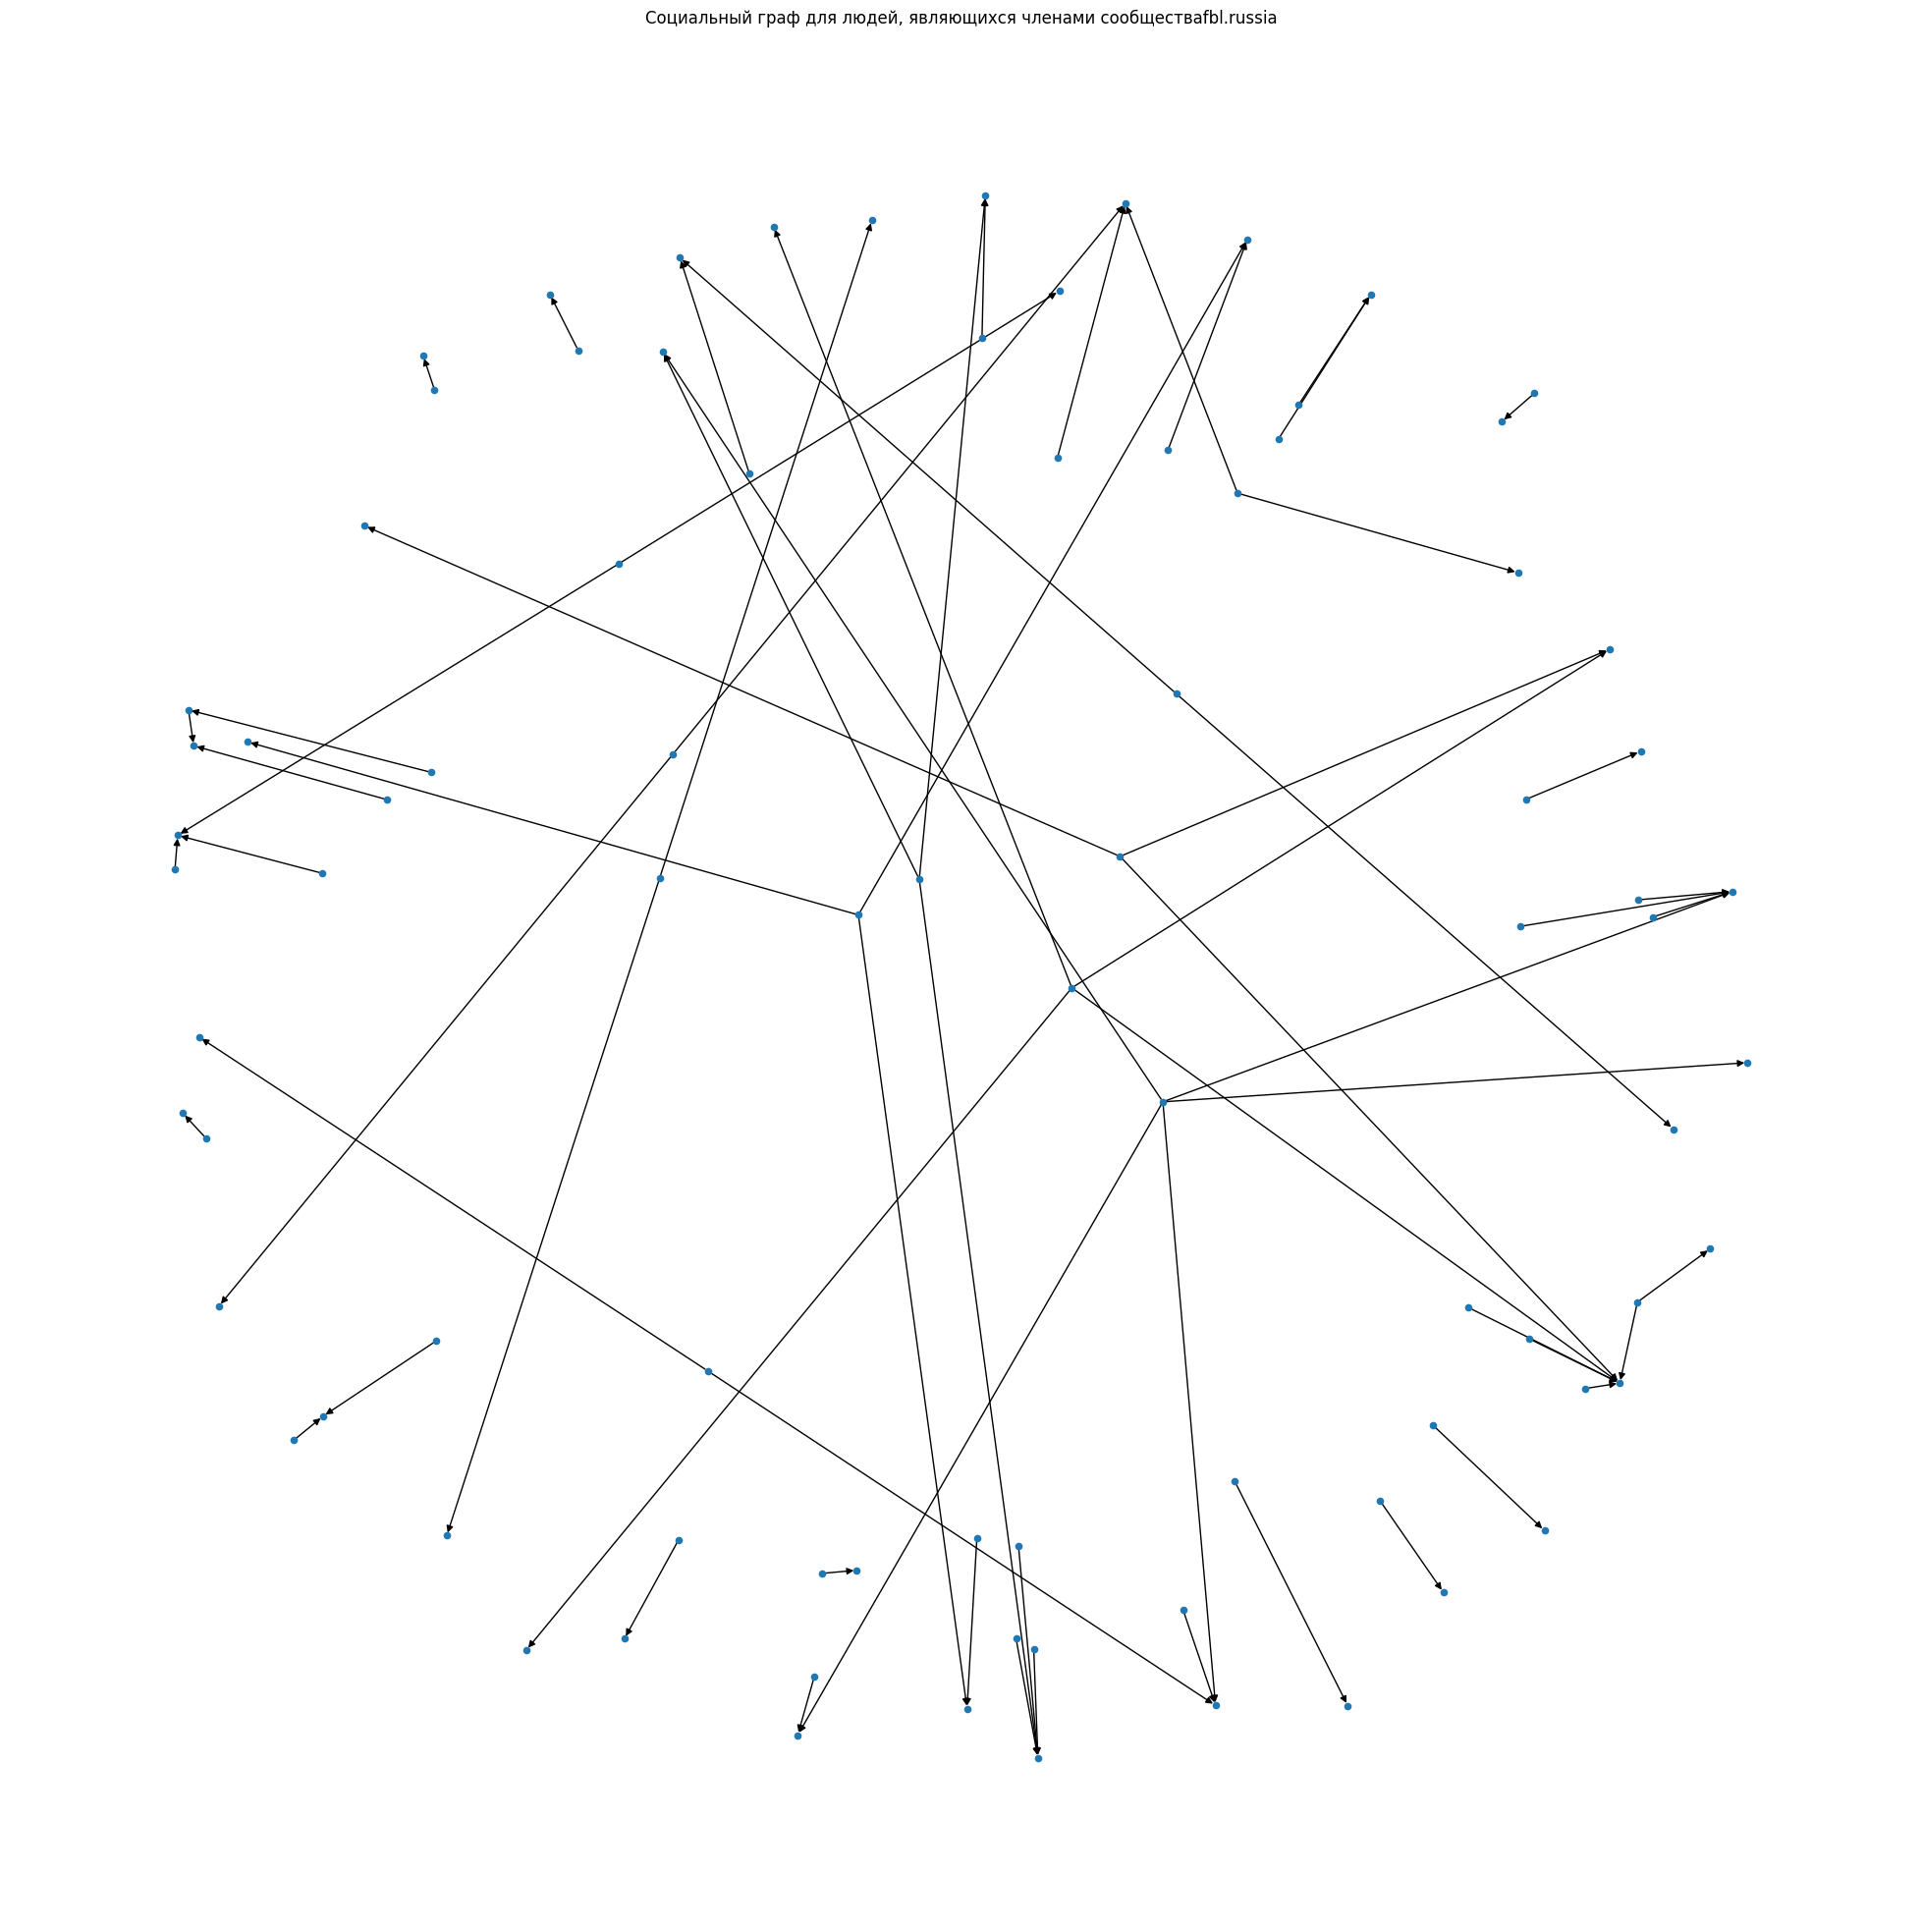

In [43]:
plt.figure(figsize=(25, 25))
plt.title('Социальный граф для людей, являющихся членами сообщества' + clubname_2)
nx.draw(G3, node_size=20)
plt.show()

# ***Сообщества внутри социальных графов***

In [44]:
k_cores_size = []                                      # Создаём пустой список, в который поместим результаты работы k-core (максимальный подграф, содержащий вершины степени k или выше.)
for i in range(1, 15):                                 # Создаём цикл от 1 до 15
    k_cores_size.append(len(nx.k_core(G, i).nodes()))  # Помещаем длину для каждого значения в список

In [45]:
for i, n in enumerate(k_cores_size):                  # Для каждого значения из списка выше
    print('Количество вершин в %s-core:' % (i+1), n)  # делаем вывод

Количество вершин в 1-core: 67
Количество вершин в 2-core: 55
Количество вершин в 3-core: 23
Количество вершин в 4-core: 21
Количество вершин в 5-core: 0
Количество вершин в 6-core: 0
Количество вершин в 7-core: 0
Количество вершин в 8-core: 0
Количество вершин в 9-core: 0
Количество вершин в 10-core: 0
Количество вершин в 11-core: 0
Количество вершин в 12-core: 0
Количество вершин в 13-core: 0
Количество вершин в 14-core: 0


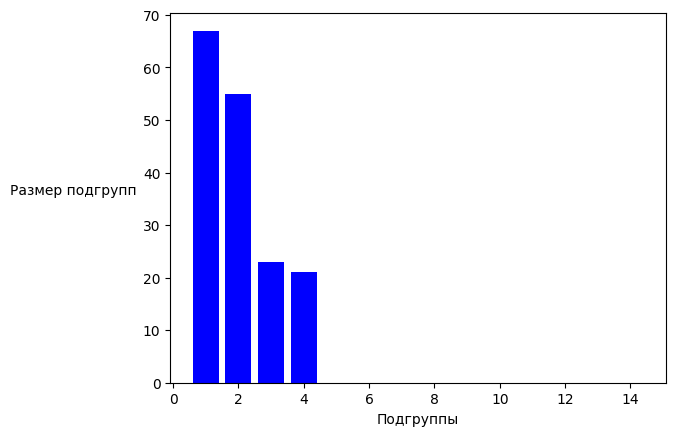

In [46]:
k_dict = {}                                                     # Создаём пустой словарь
for i, n in enumerate(k_cores_size):                            # Создаём цикл, который пройдет по каждому значению списка
    k_dict[n] = i+1                                             # Добавим длины и k в словарь

plt.bar(list(k_dict.values()), list(k_dict.keys()), color='b')  # Построение столбчатой диаграммы
plt.xlabel('Подгруппы')                                         
plt.ylabel('Размер подгрупп',rotation=0, labelpad=50)           
plt.show()                                                      

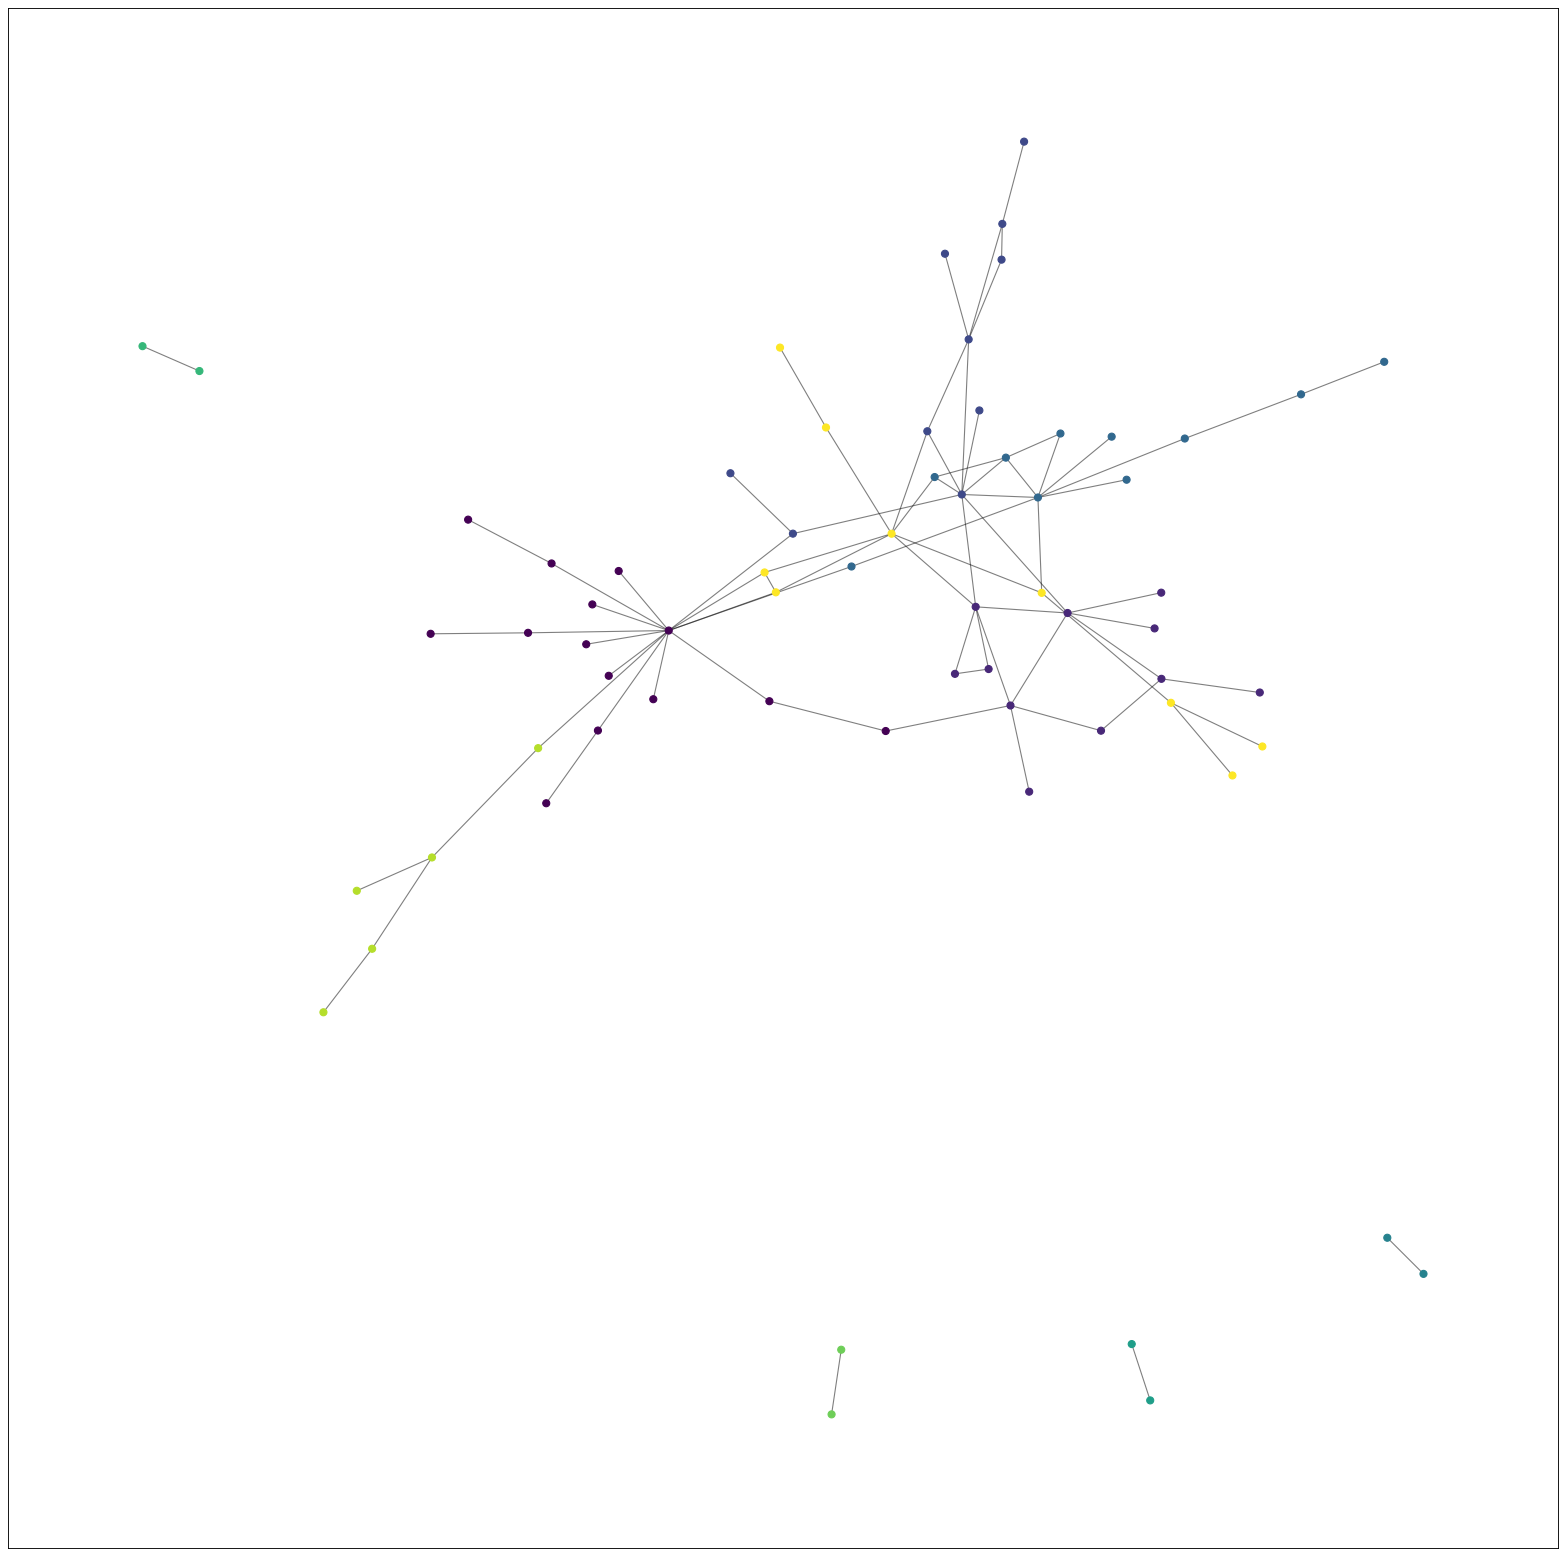

In [47]:
import community.community_louvain as community_louvain
from matplotlib.pyplot import figure
figure(figsize=(25, 25), dpi=80)                                          # Изменение размера графика
partition = community_louvain.best_partition(G1)                          # С помощью метода Лувейна ищем лучшие разделения
pos = nx.spring_layout(G1)                                                # Располагаем узлы с помощью алгоритма Фрухтремана-Рейнгольда
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)                # Определяем цветовую схему графика
nx.draw_networkx_nodes(G1, pos, partition.keys(), node_size=40,           # Cтроим узлы с задаными параметрами
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G1, pos, alpha=0.5)                                # Строим рёбра с задаными параметрами
plt.show() 

In [49]:
from networkx.algorithms import community
partition = community.louvain_communities(G1)  # Применяем тот же метод Лувейна из библиотеки networkx
print(len(partition))                          # Узнаём количество выделенных сообществ

10


In [50]:
partition_len=[]                                             # Создаём пустой список, в который поместим номер сообщества и его длину
i = 0
for el in partition:                                         # Для каждого значения, полученного методом Лувейна,
  partition_len.append([i, len(el)])                         # добавляем его в список
  i += 1                                                      
a = sorted(partition_len, key=lambda x: x[1], reverse=True)  # Сортируем список по уменьшению размера сообщества

In [51]:
part = []                          # Создаём пустой список, в который добавим номер сообществ  
for el in a[:10]:                  # Создаём цикл, который рассматривает все значения из топ-10
  part.append(partition[el[0]])    # Добавляем номер сообщества в список

part_ = {}                         # Создаём пустой словарь для создания словаря по подобию работы функции community_louvain.best_partition(G1)
ind = 0                            # Задаём значение 0 для переменной i
for el in part:                    # Создаём цикл, который рассматривает каждое значение в списке
  for i in el:                     # Создаём цикл, который рассматривает каждое значение из цикла выше
    part_[i] = ind                 # Добавляем значение в словарь
    ind += 1                       # Увеличиваем переменную i на единицу

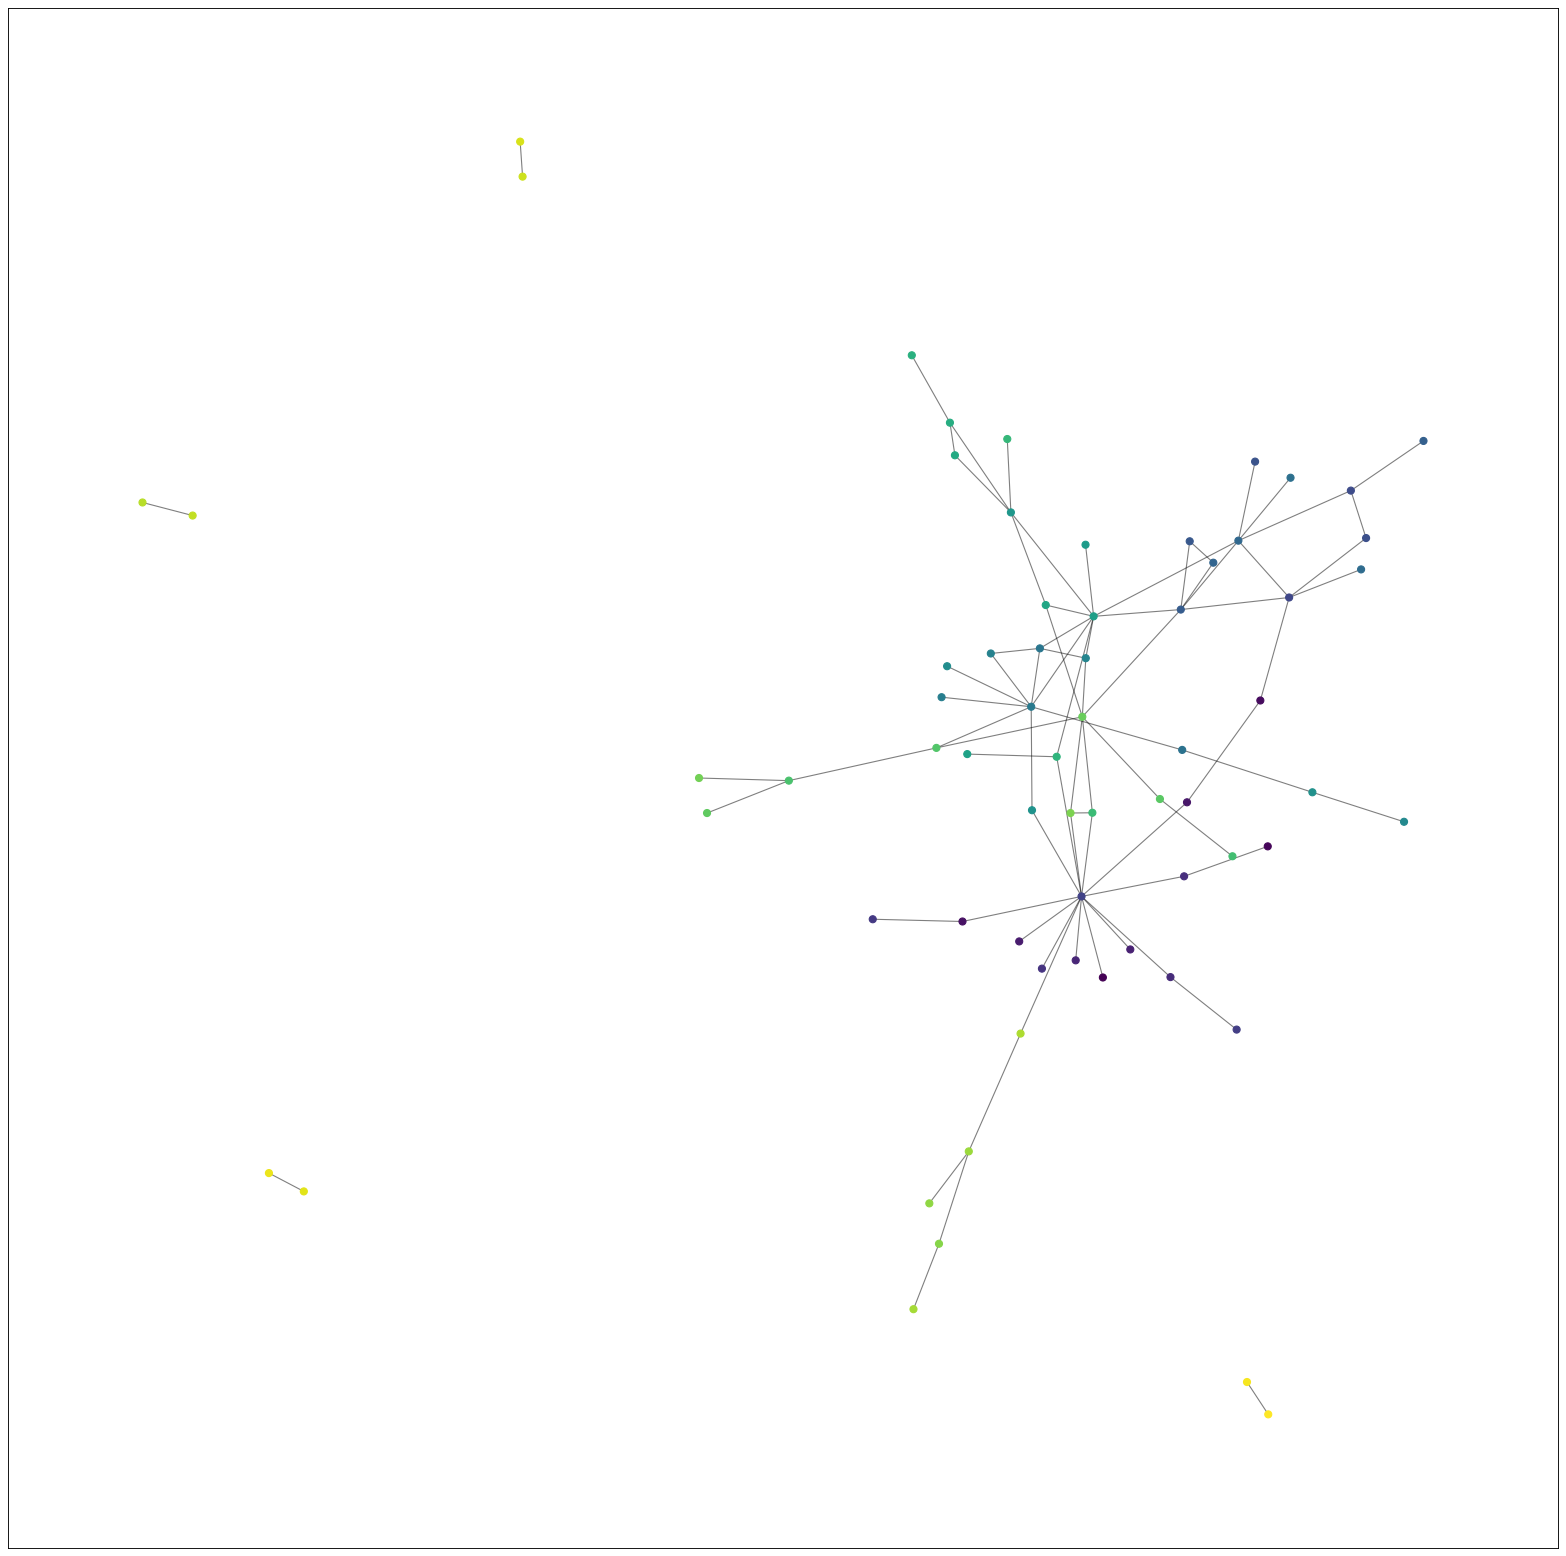

In [52]:
import community.community_louvain as community_louvain
from matplotlib.pyplot import figure
figure(figsize=(25, 25), dpi=80)                                          # Изменяем размер графика
partition = part_                                                         # Добавляем найденные нами разделения из топ-10
pos = nx.spring_layout(G1)                                                # Располагаем узлы с помощью алгоритма Фрухтремана-Рейнгольда
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)                # Определяем цветовую схему графика
nx.draw_networkx_nodes(G1, pos, partition.keys(), node_size=40,           # Cтроим узлы с задаными параметрами
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G1, pos, alpha=0.5)                                # Строим рёбра с задаными параметрами
plt.show()                                                                # Выводим график